In [527]:
%load_ext autoreload
%autoreload 2
# %matplotlib qt5
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.optimize import curve_fit


from qick import *
from qick.helpers import gauss

import h5py

import time
import os
import sys
sys.path.append('/home/xilinx/jupyter_notebooks/')
import scipy as sp
import json
from scipy.fft import fft, fftfreq
import Pyro4.util

from slab.instruments import *
from slab.experiment import Experiment
from slab.datamanagement import SlabFile
from slab import get_next_filename, AttrDict

Could not import QickInstrument (will only work if running on rfsoc). If running on rfsoc, try install/update qick package
Warning failed to import AWG81180A
Warning failed to import Tek5014
Warning failed to import Tek70001
Warning failed to import M8195A


c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py:12: ShimWarning: The `IPython.qt` package has been deprecated since IPython 4.0. You should import from qtconsole instead.
  warn("The `IPython.qt` package has been deprecated since IPython 4.0. "


Could not load InstrumentManagerWindow
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [3]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from QSwitch import QSwitch
from PulseSequence import PulseSequence
import experiments as meas
from TomoAnalysis import TomoAnalysis
tomo_analysis = TomoAnalysis(nb_qubits=3)
import qutip as qt
import matplotlib.style as style
style.use('S:\Connie\prx.mplstyle')

imported experiments.clifford_averager_program
imported experiments.fitting
imported experiments.four_qubit.fourQ_state_tomo
imported experiments.qram_protocol_timestepped
imported experiments.single_qubit.acstarkshift_spectroscopy
imported experiments.single_qubit.amplitude_rabi
imported experiments.single_qubit.length_rabi
imported experiments.single_qubit.pulse_probe_spectroscopy
imported experiments.single_qubit.resonator_spectroscopy
imported experiments.single_qubit.rfsoc_tof_calibration
imported experiments.single_qubit.single_shot
imported experiments.single_qubit.t1
imported experiments.single_qubit.t2_ramsey
imported experiments.three_qubit.threeQ_state_tomo
imported experiments.two_qubit.amplitude_rabi_EgGf
imported experiments.two_qubit.amplitude_rabi_f0g1
imported experiments.two_qubit.amprabi_opt_ctrl_state_prep
imported experiments.two_qubit.crosstalk_echo_calib
imported experiments.two_qubit.length_rabi_EgGf
imported experiments.two_qubit.length_rabi_F0G1
imported exper

In [4]:
"""Reopen saved data"""
def prev_data(expt_path, filename=None):
    temp_data_file = expt_path
    if filename is not None: temp_data_file = os.path.join(expt_path, filename)
    print(temp_data_file)
    with SlabFile(temp_data_file) as a:
        attrs = dict()
        for key in list(a.attrs):
            attrs.update({key:json.loads(a.attrs[key])})
        keys = list(a)
        temp_data = dict()
        for key in keys:
            temp_data.update({key:np.array(a[key])})
        print(f'Extracted data and attrs {list(a.attrs)}')
    return temp_data, attrs

In [5]:
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.path.join('s:\\Connie\\experiments\\qram_tprocv1_expts\\configs\\', config_file)
print('Config will be', config_path)

Config will be s:\Connie\experiments\qram_tprocv1_expts\configs\config_q3diamond_full688and638_reset.yml


# Save paths

In [6]:
save_plot_path = 'S:\\QRAM\\qram_4QR2\\plots\\paper'

# Some nice gradients

In [ ]:
# Thanks google AI

def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip("#")
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

def rgb_to_hex(rgb_color):
    return "#{:02x}{:02x}{:02x}".format(*rgb_color)

def color_gradient(start_hex, end_hex, steps):
    start_rgb = hex_to_rgb(start_hex)
    end_rgb = hex_to_rgb(end_hex)
    
    gradient_colors = []
    for i in range(steps):
        r = int(start_rgb[0] + (end_rgb[0] - start_rgb[0]) * i / (steps - 1))
        g = int(start_rgb[1] + (end_rgb[1] - start_rgb[1]) * i / (steps - 1))
        b = int(start_rgb[2] + (end_rgb[2] - start_rgb[2]) * i / (steps - 1))
        gradient_colors.append(rgb_to_hex((r, g, b)))
    return gradient_colors

# start_color = "#247a24"
# end_color = "#3ac53a"
# num_steps = 100

# gradient_hex_colors = color_gradient(start_color, end_color, num_steps)

# Swap length rabi

In [53]:
data_dir = 'S:\QRAM\qram_4QR2\data'

In [54]:
filename_q1q3_right = '00071_length_rabi_EgGf_qubit31.h5'
filename_q1q3_wrong = '00072_length_rabi_EgGf_qubit31.h5'
filename_q1q2_right = '00070_length_rabi_EgGf_qubit21.h5'
filename_q1q2_wrong = '00071_length_rabi_EgGf_qubit21.h5'

folder = 'data_250119'

files = []

for f in [filename_q1q3_right, filename_q1q3_wrong, filename_q1q2_right, filename_q1q2_wrong]:
    file = h5py.File(data_dir + '/' + folder + '/' + f, 'r')
    files.append(file)

In [55]:
t13_right = 2*np.asarray(files[0]['xpts']) # multiply by 2 to get the pi length
t13_wrong = 2*np.asarray(files[1]['xpts'])
t12_right = 2*np.asarray(files[2]['xpts'])
t12_wrong = 2*np.asarray(files[3]['xpts'])

# amp_13_right = np.asarray(files[0]['avgi'])
# amp_13_wrong = np.asarray(files[1]['avgi'])
amp_13_right = np.asarray(files[0]['amps'])
amp_13_wrong = np.asarray(files[1]['amps'])

amp_12_right = np.asarray(files[2]['avgi'])
amp_12_wrong = np.asarray(files[3]['avgi'])

# amp_13_right = np.abs(np.asarray(files[0]['avgi']) + 1j*np.asarray(files[0]['avgq']))
# amp_13_wrong = np.abs(np.asarray(files[1]['avgi']) + 1j*np.asarray(files[1]['avgq']))
# amp_12_right = np.abs(np.asarray(files[2]['avgi']) + 1j*np.asarray(files[2]['avgq']))
# amp_12_wrong = np.abs(np.asarray(files[3]['avgi']) + 1j*np.asarray(files[3]['avgq']))

 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\3192873655.py: 1DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\3192873655.py: 2DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\3192873655.py: 3DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\3192873655.py: 4DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\3192873655.py: 8DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_3

25011900071_25011900072_25011900070_25011900071__length_rabi_EgGf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900071_25011900072_25011900070_25011900071__length_rabi_EgGf.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900071_25011900072_25011900070_25011900071__length_rabi_EgGf.svg


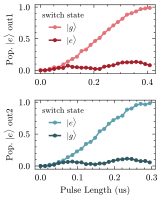

In [64]:
color_dict = {'q1q3_right': '#5b9faeff', 'q1q3_wrong': '#2f5760ff', 'q1q2_right': '#e5717aff', 'q1q2_wrong': '#a31f29ff'}

fig, ax = plt.subplots(2, 1, figsize=(2.5, 3))
# fig, ax = plt.subplots(2, 1, figsize=(2.0, 3))


y3_right = amp_13_right[0]
y3_wrong = amp_13_wrong[0]

y13_1_scaled = (y3_right - y3_right[0])/(np.max(y3_right) - np.min(y3_right))
# y13_2_scaled = (y2 - np.min(y3_right))/(np.max(y3_right) - np.min(y3_right)) 
y13_2_scaled = (y3_wrong - y3_wrong[0])/(np.max(y3_right) - np.min(y3_right)) 

# y13_1_scaled = y 
# y13_2_scaled = y2


y2_right = amp_12_right[0]
y2_wrong = amp_12_wrong[0]

y12_1_scaled = (y2_right - y2_right[0])/(np.max(y2_right) - np.min(y2_right))
# y12_2_scaled = (y2 - np.min(y2_right))/(np.max(y2_right) - np.min(y2_right))
y12_2_scaled = (y2_wrong - y2_wrong[0])/(np.max(y2_right) - np.min(y2_right))

# y12_1_scaled = y 
# y12_2_scaled = y2


# fit both with a sine function

# def fit_sin(x, A, B, C, D):
#     return A*np.sin(B*x + C) + D

# popt1, pcov1 = opt.curve_fit(fit_sin, t13_right, y13_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt2, pcov2 = opt.curve_fit(fit_sin, t13_wrong, y13_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)
# popt3, pcov3 = opt.curve_fit(fit_sin, t12_right, y12_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt4, pcov4 = opt.curve_fit(fit_sin, t12_wrong, y12_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)

# y13_1_fit = fit_sin(t13_right, *popt1)
# y13_2_fit = fit_sin(t13_wrong, *popt2)
# y12_1_fit = fit_sin(t12_right, *popt3)
# y12_2_fit = fit_sin(t12_wrong, *popt4)

# idx_stop_12 = -1
# idx_stop_13 = -1
idx_stop_12 = np.argmax(y12_1_scaled)# + 2
idx_stop_13 = np.argmax(y13_1_scaled)# + 2

ax[1].plot(t13_right[:idx_stop_13], y13_1_scaled[:idx_stop_13], 'o-', label=r'$|e\rangle$', color=color_dict['q1q3_right'])
ax[1].plot(t13_wrong[:idx_stop_13], y13_2_scaled[:idx_stop_13], 'o-', label=r'$|g\rangle$', color=color_dict['q1q3_wrong'])
# ax[1].plot(t13_right[:idx_stop_13], y13_1_fit[:idx_stop_13], color=color_dict['q1q3_right'])
# ax[1].plot(t13_wrong[:idx_stop_13], y13_2_fit[:idx_stop_13], color=color_dict['q1q3_wrong'])
# set subtitle
# ax[1].set_title('input - output 2')

ax[0].plot(t12_right[:idx_stop_12], y12_1_scaled[:idx_stop_12], 'o-', label=r'$|g\rangle$', color=color_dict['q1q2_right'])
ax[0].plot(t12_wrong[:idx_stop_12], y12_2_scaled[:idx_stop_12], 'o-', label=r'$|e\rangle$', color=color_dict['q1q2_wrong'])
# ax[0].plot(t12_right[:idx_stop_12], y12_1_fit[:idx_stop_12], color=color_dict['q1q2_right'])
# ax[0].plot(t12_wrong[:idx_stop_12], y12_2_fit[:idx_stop_12], color=color_dict['q1q2_wrong'])
# set subtitle
# ax[0].set_title('input - output 1')

ax[0].set_ylabel(r'Pop. $|e\rangle$ out1')
ax[1].set_ylabel(r'Pop. $|e\rangle$ out2')

ax[1].set_xlabel('Pulse Length (us)')

ax[0].legend(title='switch state', frameon=False)
ax[1].legend(title='switch state', frameon=False)

fig.tight_layout()

filenames = [filename_q1q3_right, filename_q1q3_wrong, filename_q1q2_right, filename_q1q2_wrong]

filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

print(filepaths_str)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)

25011900071_25011900072_25011900070_25011900071__length_rabi_EgGf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900071_25011900072_25011900070_25011900071__length_rabi_EgGf.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\rabi_eg_gf_25011900071_25011900072_25011900070_25011900071__length_rabi_EgGf.svg


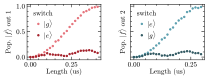

In [215]:
color_dict = {'q1q3_right': '#5b9faeff', 'q1q3_wrong': '#2f5760ff', 'q1q2_right': '#e5717aff', 'q1q2_wrong': '#a31f29ff'}

labelsize = 7

fig, ax = plt.subplots(1, 2, figsize=(3.0, 1.0), sharey=True)
fig.subplots_adjust(hspace=0.2, wspace=0.4)
# fig, ax = plt.subplots(2, 1, figsize=(2.0, 3))


y3_right = amp_13_right[0]
y3_wrong = amp_13_wrong[0]

y13_1_scaled = (y3_right - y3_right[0])/(np.max(y3_right) - np.min(y3_right))
# y13_2_scaled = (y2 - np.min(y3_right))/(np.max(y3_right) - np.min(y3_right)) 
y13_2_scaled = (y3_wrong - y3_wrong[0])/(np.max(y3_right) - np.min(y3_right)) 

# y13_1_scaled = y 
# y13_2_scaled = y2


y2_right = amp_12_right[0]
y2_wrong = amp_12_wrong[0]

y12_1_scaled = (y2_right - y2_right[0])/(np.max(y2_right) - np.min(y2_right))
# y12_2_scaled = (y2 - np.min(y2_right))/(np.max(y2_right) - np.min(y2_right))
y12_2_scaled = (y2_wrong - y2_wrong[0])/(np.max(y2_right) - np.min(y2_right))

# y12_1_scaled = y 
# y12_2_scaled = y2


# fit both with a sine function

# def fit_sin(x, A, B, C, D):
#     return A*np.sin(B*x + C) + D

# popt1, pcov1 = opt.curve_fit(fit_sin, t13_right, y13_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt2, pcov2 = opt.curve_fit(fit_sin, t13_wrong, y13_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)
# popt3, pcov3 = opt.curve_fit(fit_sin, t12_right, y12_1_scaled, p0=[0.5, 2*np.pi/0.5, np.pi/2, 0.5], maxfev=10000)
# popt4, pcov4 = opt.curve_fit(fit_sin, t12_wrong, y12_2_scaled, p0=[0.05, 2*np.pi/4, np.pi/2, 0.01], maxfev=10000)

# y13_1_fit = fit_sin(t13_right, *popt1)
# y13_2_fit = fit_sin(t13_wrong, *popt2)
# y12_1_fit = fit_sin(t12_right, *popt3)
# y12_2_fit = fit_sin(t12_wrong, *popt4)

# idx_stop_12 = -1
# idx_stop_13 = -1
idx_stop_12 = np.argmax(y12_1_scaled)# + 2
idx_stop_13 = np.argmax(y13_1_scaled)# + 2

ax[1].plot(t13_right[:idx_stop_13], y13_1_scaled[:idx_stop_13], '.', label=r'$|e\rangle$', color=color_dict['q1q3_right'])
ax[1].plot(t13_wrong[:idx_stop_13], y13_2_scaled[:idx_stop_13], '.', label=r'$|g\rangle$', color=color_dict['q1q3_wrong'])
# ax[1].plot(t13_right[:idx_stop_13], y13_1_fit[:idx_stop_13], color=color_dict['q1q3_right'])
# ax[1].plot(t13_wrong[:idx_stop_13], y13_2_fit[:idx_stop_13], color=color_dict['q1q3_wrong'])
# set subtitle
# ax[1].set_title('input - output 2')

ax[0].plot(t12_right[:idx_stop_12], y12_1_scaled[:idx_stop_12], '.', label=r'$|g\rangle$', color=color_dict['q1q2_right'])
ax[0].plot(t12_wrong[:idx_stop_12], y12_2_scaled[:idx_stop_12], '.', label=r'$|e\rangle$', color=color_dict['q1q2_wrong'])
# ax[0].plot(t12_right[:idx_stop_12], y12_1_fit[:idx_stop_12], color=color_dict['q1q2_right'])
# ax[0].plot(t12_wrong[:idx_stop_12], y12_2_fit[:idx_stop_12], color=color_dict['q1q2_wrong'])
# set subtitle
# ax[0].set_title('input - output 1')

ax[0].set_ylabel(r'Pop. $|f\rangle$ out 1', fontsize=labelsize)
# ax[1].set_ylabel(r'Pop. $|e\rangle$ out2')

ax[0].set_xlabel('Length (us)', fontsize=labelsize, labelpad=0.3)
ax[0].set_xticks([0, 0.25])
ax[0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax[0].legend(title='switch', frameon=False, handletextpad=0.1, title_fontsize=labelsize, fontsize=labelsize) #, frameon=True, framealpha=0.7

ax[1].set_ylabel(r'Pop. $|f\rangle$ out 2', fontsize=labelsize)
ax[1].set_xlabel('Length (us)', fontsize=labelsize, labelpad=0.3)
ax[1].set_xticks([0, 0.25])
ax[1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)

ax[1].legend(title='switch', frameon=False, handletextpad=0.1, title_fontsize=labelsize, fontsize=labelsize) #, frameon=True, framealpha=0.7

# fig.tight_layout()

filenames = [filename_q1q3_right, filename_q1q3_wrong, filename_q1q2_right, filename_q1q2_wrong]

filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

print(filepaths_str)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'calib', f'rabi_eg_gf_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)

# Chevron right / wrong state

In [57]:
chevron_filename_q1q3_right = '00000_rabi_EgGf_freqlen_chevron_qubit31.h5'
chevron_filename_q1q3_wrong = '00001_rabi_EgGf_freqlen_chevron_qubit31.h5'
chevron_filename_q1q2_right = '00000_rabi_EgGf_freqlen_chevron_qubit21.h5'
chevron_filename_q1q2_wrong = '00001_rabi_EgGf_freqlen_chevron_qubit21.h5'


folder = 'data_250119'

files = []

for f in [chevron_filename_q1q3_right, chevron_filename_q1q3_wrong, chevron_filename_q1q2_right, chevron_filename_q1q2_wrong]:
    file = h5py.File(data_dir + '/' + folder + '/' + f, 'r')
    files.append(file)

In [58]:
qb_plot = 0
data_13 = 'amps'
data_12 = 'avgi'

amp_13_right_2d = np.asarray(files[0][data_13])
amp_13_wrong_2d = np.asarray(files[1][data_13])
amp_12_right_2d = np.asarray(files[2][data_12])
amp_12_wrong_2d = np.asarray(files[3][data_12])

freqs_13_right = np.asarray(files[0]['freqpts'])
freqs_13_wrong = np.asarray(files[1]['freqpts'])
freqs_12_right = np.asarray(files[2]['freqpts'])
freqs_12_wrong = np.asarray(files[3]['freqpts'])

t13_right_2d = np.asarray(files[0]['lenpts'])*2*1e-3
t13_wrong_2d = np.asarray(files[1]['lenpts'])*2*1e-3
t12_right_2d = np.asarray(files[2]['lenpts'])*2*1e-3
t12_wrong_2d = np.asarray(files[3]['lenpts'])*2*1e-3




 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1164440199.py: 5DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1164440199.py: 6DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1164440199.py: 7DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1164440199.py: 8DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1164440199.py: 10DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
 C:\Users\slab\AppData\Local\Temp\ipykernel_

In [59]:
import matplotlib as mpl

Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900000_25011900001__rabi_EgGf_freqlen_chevron_13.pdf


 C:\Users\slab\AppData\Roaming\Python\Python39\site-packages\matplotlib\ticker.py: 2937

Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900000_25011900001__rabi_EgGf_freqlen_chevron_12.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900000_25011900001__rabi_EgGf_freqlen_chevron_13.svg


 C:\Users\slab\AppData\Roaming\Python\Python39\site-packages\matplotlib\ticker.py: 2937

Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_25011900000_25011900001__rabi_EgGf_freqlen_chevron_12.svg


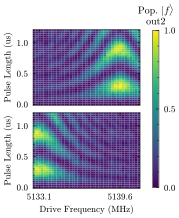

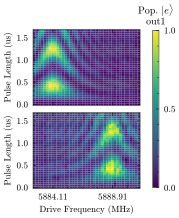

In [210]:
# fig, axes = plt.subplots(gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(2.5, 3))

fig, ax = plt.subplots(2, 1, figsize=(2.5*0.85, 3*0.95), sharex=True)
# fig, ax = plt.subplots(2, 1, figsize=(2.0*0.85, 3*0.95), sharex=True)
fig.subplots_adjust(hspace=0.1)

f_right_13 = 5139.60
f_wrong_13 = f_right_13 - 6.5

f_right_12 = 5884.11
f_wrong_12 = f_right_12 + 4.8

y_12_right_2d = -amp_12_right_2d[qb_plot].T ## minus sign to match the amplitude of the other qubit
y_12_wrong_2d = -amp_12_wrong_2d[qb_plot].T

y_12_right_scaled_2d = (y_12_right_2d - y_12_right_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))
y_12_wrong_scaled_2d = (y_12_wrong_2d - y_12_wrong_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))

y_13_right_2d = amp_13_right_2d[qb_plot].T
y_13_wrong_2d = amp_13_wrong_2d[qb_plot].T 
y_13_right_scaled_2d = (y_13_right_2d - y_13_right_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))
y_13_wrong_scaled_2d = (y_13_wrong_2d - y_13_wrong_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))


x_12_right_2d = freqs_12_right # - f_right_12
x_12_wrong_2d = freqs_12_wrong # - f_right_12

x_13_right_2d = freqs_13_right # - f_right_13
x_13_wrong_2d = freqs_13_wrong # - f_right_13


ax[0].pcolor(x_13_right_2d, t13_right_2d*1e3,y_13_right_scaled_2d, cmap='viridis')
ax[1].pcolor(x_13_wrong_2d, t13_wrong_2d*1e3, y_13_wrong_scaled_2d, cmap='viridis')

ax[1].set_ylabel('Pulse Length (us)')
ax[0].set_ylabel('Pulse Length (us)')
ax[1].set_xticks([f_right_13, f_wrong_13])


# add a colorbar

cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), ax=ax, location='right', aspect=25, ticks=[0, 0.5, 1], fraction=0.05, pad=0.1)
cbar.ax.set_title(r'Pop. $|f\rangle$' + '\nout2', fontsize=10)

# put the colorbar closer to the figurer

cbar.ax.yaxis.set_ticks_position('right')
cbar.ax.yaxis.set_label_position('right')

# ax[1].set_xlabel('$f - f_\mathrm{eg-gf}^\mathrm{in-out2}$ (MHz)')
ax[1].set_xlabel('Drive Frequency (MHz)')



# fig.tight_layout()


fig2, ax2 = plt.subplots(2, 1, figsize=(2.5*0.85, 3*0.95), sharex=True)
# fig2, ax2 = plt.subplots(2, 1, figsize=(2.0*0.85, 3*0.95), sharex=True)
fig2.subplots_adjust(hspace=0.1)


ax2[0].pcolor(x_12_right_2d, t12_right_2d*1e3, y_12_right_scaled_2d, cmap='viridis')
ax2[1].pcolor(x_12_wrong_2d, t12_wrong_2d*1e3, y_12_wrong_scaled_2d, cmap='viridis')

# ax2[1].set_xlabel('$f - f_\mathrm{eg-gf}^\mathrm{in-out1}$ (MHz)')
ax2[1].set_xlabel('Drive Frequency (MHz)')
ax2[1].set_ylabel('Pulse Length (us)')
ax2[0].set_ylabel('Pulse Length (us)')
ax2[1].set_xticks([f_right_12, f_wrong_12])



cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), ax=ax2, location='right', aspect=25, ticks=[0, 0.5, 1], fraction=0.05, pad=0.1)
cbar.ax.set_title(r'Pop. $|e\rangle$' + '\nout1', fontsize=10)


for filetype in ['pdf', 'svg']:
    filenames = [chevron_filename_q1q3_right, chevron_filename_q1q3_wrong]
    filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    savename = os.path.join(save_plot_path, 'calib', f'chevron_{filepaths_str}_13.{filetype}')
    print("Saving", savename)
    fig.savefig(savename)


    filenames = [chevron_filename_q1q2_right, chevron_filename_q1q2_wrong]
    filepaths_str = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    savename = os.path.join(save_plot_path, 'calib', f'chevron_{filepaths_str}_12.{filetype}')
    print("Saving", savename)
    fig2.savefig(savename)

## All the chevrons together

Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_combined_25011900000_25011900001__rabi_EgGf_freqlen_chevron_25011900000_25011900001__rabi_EgGf_freqlen_chevron.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\calib\chevron_combined_25011900000_25011900001__rabi_EgGf_freqlen_chevron_25011900000_25011900001__rabi_EgGf_freqlen_chevron.svg


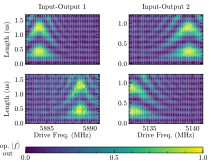

In [211]:
labelsize = 7
# fig, axes = plt.subplots(gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(2.5, 3))

fig, ax = plt.subplots(2, 2, figsize=(3.0, 2.8))
# fig, ax = plt.subplots(2, 1, figsize=(2.0*0.85, 3*0.95), sharex=True)
fig.subplots_adjust(hspace=0.2, wspace=0.4)

f_right_13 = 5139.60
f_wrong_13 = f_right_13 - 6.5

f_right_12 = 5884.11
f_wrong_12 = f_right_12 + 4.8

y_12_right_2d = -amp_12_right_2d[qb_plot].T ## minus sign to match the amplitude of the other qubit
y_12_wrong_2d = -amp_12_wrong_2d[qb_plot].T

y_12_right_scaled_2d = (y_12_right_2d - y_12_right_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))
y_12_wrong_scaled_2d = (y_12_wrong_2d - y_12_wrong_2d[0])/(np.max(y_12_right_2d) - np.min(y_12_right_2d))

y_13_right_2d = amp_13_right_2d[qb_plot].T
y_13_wrong_2d = amp_13_wrong_2d[qb_plot].T 
y_13_right_scaled_2d = (y_13_right_2d - y_13_right_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))
y_13_wrong_scaled_2d = (y_13_wrong_2d - y_13_wrong_2d[0])/(np.max(y_13_right_2d) - np.min(y_13_right_2d))


x_12_right_2d = freqs_12_right # - f_right_12
x_12_wrong_2d = freqs_12_wrong # - f_right_12

x_13_right_2d = freqs_13_right # - f_right_13
x_13_wrong_2d = freqs_13_wrong # - f_right_13



# COLUMN 1 FOR Q1-Q2
ax[0, 0].set_title("Input-Output 1", fontsize=labelsize)
ax[0, 0].pcolor(x_12_right_2d, t12_right_2d*1e3, y_12_right_scaled_2d, cmap='viridis')
ax[1, 0].pcolor(x_12_wrong_2d, t12_wrong_2d*1e3, y_12_wrong_scaled_2d, cmap='viridis')
ax[1, 0].set_xlabel('Drive Freq. (MHz)', fontsize=labelsize, labelpad=0.1)
ax[1, 0].set_ylabel('Length (us)', fontsize=labelsize)
ax[0, 0].set_ylabel('Length (us)', fontsize=labelsize)
ax[0, 0].set_yticks([0, 0.5, 1.0, 1.5])
ax[1, 0].set_yticks([0, 0.5, 1.0, 1.5])
plt.setp(ax[0, 0].get_xticklabels(), visible=False)
ax[1, 0].set_xticks([f_right_12, f_wrong_12])
ax[1, 0].sharex(ax[0, 0])

for i in range(2):
    for j in range(2):
        ax[i, j].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)


# COLUMN 2 FOR Q1-Q3
ax[0, 1].set_title("Input-Output 2", fontsize=labelsize)
ax[0, 1].pcolor(x_13_right_2d, t13_right_2d*1e3,y_13_right_scaled_2d, cmap='viridis')
ax[1, 1].pcolor(x_13_wrong_2d, t13_wrong_2d*1e3, y_13_wrong_scaled_2d, cmap='viridis')
ax[1, 1].set_xlabel('Drive Freq. (MHz)', fontsize=labelsize, labelpad=0.1)
# ax[1, 1].set_ylabel('Pulse Length (us)')
# ax[0, 1].set_ylabel('Pulse Length (us)')
ax[0, 1].set_yticks([0, 0.5, 1.0])
ax[1, 1].set_yticks([0, 0.5, 1.0])
plt.setp(ax[0, 1].get_xticklabels(), visible=False)
ax[1, 1].set_xticks([f_right_13, f_wrong_13])
ax[1, 1].sharex(ax[0, 1])


# add a colorbar
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap='viridis'), ax=ax, location='bottom', aspect=30, ticks=[0, 0.5, 1], pad=0.15)
cbar.ax.set_xlabel(r'Pop. $|f\rangle$' + '\nout', fontsize=labelsize) #, x=0, ha='left') # , loc='left', x=0.5) #, size=10)
cbar.ax.xaxis.set_label_coords(-0.1, 2.0)
cbar.ax.tick_params(labelsize=labelsize, pad=2)

# put the colorbar closer to the figure
cbar.ax.xaxis.set_ticks_position('bottom')
cbar.ax.xaxis.set_label_position('bottom')


for filetype in ['pdf', 'svg']:
    filenames = [chevron_filename_q1q3_right, chevron_filename_q1q3_wrong]
    filepaths_str_13 = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    filenames = [chevron_filename_q1q2_right, chevron_filename_q1q2_wrong]
    filepaths_str_12 = '_'.join([folder[5:] + filename[:5] for filename in filenames]) + '_'+filenames[0][5:-11]

    filepaths_str = filepaths_str_13 + '_' + filepaths_str_12


    savename = os.path.join(save_plot_path, 'calib', f'chevron_combined_{filepaths_str}.{filetype}')
    print("Saving", savename)
    fig.savefig(savename)

# Swap pi/-pi

In [150]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
folder = 'data_250119'
expt_path = os.path.join(data_path, 'data', folder)
print('Data dir', expt_path)

Data dir S:\QRAM\qram_4QR2\data\data_250119


In [199]:
pmp_path = "00072_PiMinusPiEgGfExptQ31"

S:\QRAM\qram_4QR2\data\data_250119\00072_PiMinusPiEgGfExptQ31.h5
Extracted data and attrs ['config']
dict_keys(['amps', 'angles', 'avgi', 'avgq', 'best_freq', 'counts_calib', 'cycle_sweep', 'fit_q1_amps', 'fit_q1_err_amps', 'fit_q3_amps', 'fit_q3_err_amps', 'freq_sweep', 'ge_avgs', 'phases', 'products', 'thresholds', 'xpts'])
Fit best freq (Q3) 5139.587865321054 which is 7.201071570465501 away from old freq 5132.386793750588
Fit best freq (Q1) 5139.593983690287 which is 7.207189939698765 away from old freq 5132.386793750588
best 0 0.062336200801551625
Best freq fitted 5139.587865321054


 C:\Users\slab\AppData\Local\Temp\ipykernel_27764\1939458940.py: 13

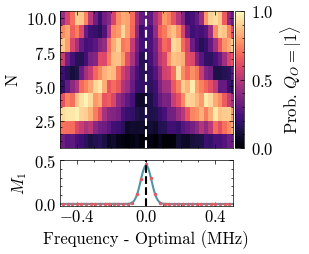

25011900072_PiMinusPiEgGfExptQ31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_25011900072_PiMinusPiEgGfExptQ31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_25011900072_PiMinusPiEgGfExptQ31.svg


In [351]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

pmp = meas.PiMinusPiEgGfExperiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pmp_path+'.h5'))
print(data.keys())
pmp.cfg = AttrDict(attrs["config"])

data = pmp.analyze(data=data, fit=True)

qA, qB = pmp.cfg.expt.qubits

inner_sweep = data["freq_sweep"]
outer_sweep = data["cycle_sweep"]

y_sweep = outer_sweep
x_sweep = inner_sweep

prod_data = data["products"][0] * data["products"][1]
x_sweep_fit = np.linspace(x_sweep[0], x_sweep[-1], 300)
popt, pcov = meas.fitting.fit_gauss(x_sweep, prod_data)
fit_freq = popt[1]

x_sweep -= fit_freq
popt[1] -= fit_freq
x_sweep_fit -= fit_freq
fit_freq = 0

labelsize = 12
cmap = 'magma'

fig, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(3.0, 2.5))

axes[1,1].remove()

a0 = axes[0, 0]
plt.sca(a0)
a0.set_ylabel(f"N", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelbottom=False, labelsize=labelsize, pad=2)
data_name = "amps"
plot_data = data[data_name][0] # 0 for qDrive, 1 for q1
scaled_e = np.max(plot_data)
scaled_g = np.min(plot_data)
scale_ge = scaled_e - scaled_g
plot_data = (plot_data - scaled_g) / scale_ge
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap=cmap, shading="auto")
plt.axvline(fit_freq, color="w", linestyle="--")

acbar = axes[0, 1]
# plt.sca(acbar)
cbar = plt.colorbar(cax=acbar, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label('Prob. $Q_O=|1\\rangle$', size=labelsize)

a1 = axes[1, 0]
a1.sharex(a0)
plt.sca(a1)
a1.set_ylabel("$M_1$", fontsize=labelsize)
a1.set_xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a1.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.plot(x_sweep_fit, meas.fitting.gaussian(x_sweep_fit, *popt))
plt.plot(x_sweep, prod_data, ".")
plt.axvline(fit_freq, color="k", linestyle="--")
# plt.ylim([-0.05, 0.6])
a1.set_yticks([0.0, 0.5])
plt.xlim([-0.5, 0.5])
a1.set_xticks([-0.4, 0, 0.4])

plt.tight_layout(pad=0.2)
plt.show()


filepaths_str = folder[5:] + pmp_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    

In [201]:
pmp_sweep_path = "00006_eggf_piminuspi_gain_sweep_Q31"

S:\QRAM\qram_4QR2\data\data_250119\00006_eggf_piminuspi_gain_sweep_Q31.h5
Extracted data and attrs ['config']
dict_keys(['amps', 'avgi', 'avgq', 'cycle_sweep', 'freq_sweep', 'gain_sweep', 'products'])


 C:\Users\slab\AppData\Local\Temp\ipykernel_27764\1939458940.py: 13

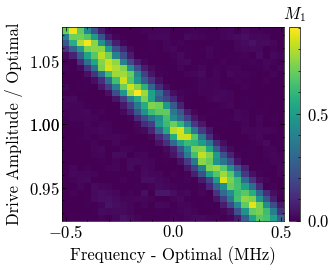

25011900006_eggf_piminuspi_gain_sweep_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_sweep_25011900006_eggf_piminuspi_gain_sweep_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\piminuspi_sweep_25011900006_eggf_piminuspi_gain_sweep_Q31.svg


In [356]:
pmp_sweep = meas.Experiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pmp_sweep_path+'.h5'))
pmp_sweep.data = data
print(data.keys())
cfg = AttrDict(attrs["config"])

qA, qB = pmp_sweep_path[-2:]
qA = int(qA)
qB = int(qB)
opt_gain = cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qA]
opt_freq = cfg.device.qubit.f_EgGf_Q_half[qA]

cycle_sweep = data["cycle_sweep"]
label = "($X_{\pi}, X_{-\pi})^N$"
# label = "($X_{\pi/2}, X_{\pi/2}, X_{-\pi/2}, X_{-\pi/2})^N$"

inner_sweep = data["freq_sweep"]
outer_sweep = data["gain_sweep"]

y_sweep = outer_sweep
x_sweep = inner_sweep

x_sweep -= opt_freq
y_sweep /= opt_gain

labelsize = 12

fig = plt.figure(figsize=(2.5*1.3, 2.0*1.3))
data_name = "products"
plot_data = data[data_name][0] * data[data_name][1]

a0 = plt.subplot(111)
a0.set_ylabel(f"Drive Amplitude / Optimal", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
plt.xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a0.set_xticks([-0.5, 0, 0.5])
ymin = np.min(y_sweep)
ymax = np.max(y_sweep)
ytick_spacing = 0.05
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
a0.set_yticks(ytick_labels)

divider = make_axes_locatable(a0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.ax.set_title("$M_1$", size=labelsize)

plt.tight_layout(pad=0.0)
plt.show()

filepaths_str = folder[5:] + pmp_sweep_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_sweep_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'piminuspi_sweep_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    
    

# Swap pi train

In [217]:
pp_path = "00071_eggf_train_Q31"

S:\QRAM\qram_4QR2\data\data_250119\00071_eggf_train_Q31.h5
Extracted data and attrs ['config']
dict_keys(['amps', 'angles', 'avgi', 'avgq', 'best_gain', 'counts_calib', 'cycle_sweep', 'fit_q1_avgi', 'fit_q1_err_avgi', 'fit_q3_avgi', 'fit_q3_err_avgi', 'gain_sweep', 'ge_avgs', 'products', 'thresholds'])
6679.170094901057


 C:\Users\slab\AppData\Local\Temp\ipykernel_27764\1939458940.py: 13

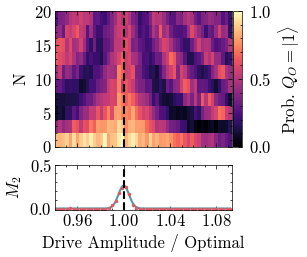

25011900071_eggf_train_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_25011900071_eggf_train_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_25011900071_eggf_train_Q31.svg


In [349]:
pp = meas.PiTrainEgGfGainSweepExperiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pp_path+'.h5'))
print(data.keys())
pp.cfg = AttrDict(attrs["config"])

# pp.analyze(data=data, fit=True)

qA, qB = pp.cfg.expt.qubits

inner_sweep = data["gain_sweep"]
outer_sweep = data["cycle_sweep"]

y_sweep = outer_sweep
x_sweep = inner_sweep

prod_data = data["products"][0] * data["products"][1]
x_sweep_fit = np.linspace(x_sweep[0], x_sweep[-1], 300)
popt, pcov = meas.fitting.fit_gauss(x_sweep, prod_data)
fit_gain = popt[1]
print(fit_gain)

x_sweep /= fit_gain
popt, pcov = meas.fitting.fit_gauss(x_sweep, prod_data)
x_sweep_fit = np.linspace(x_sweep[0], x_sweep[-1], 300)
fit_gain = 1

labelsize = 12
cmap = 'magma'

fig, axes = plt.subplots(2, 2, gridspec_kw={'height_ratios': [3, 1], 'width_ratios':[1, 0.05]}, figsize=(3.0, 2.5))

axes[1,1].remove()

a0 = axes[0, 0]
plt.sca(a0)
a0.set_ylabel(f"N", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelbottom=False, labelsize=labelsize, pad=2)
data_name = "amps"
plot_data = data[data_name][0] # 0 for qDrive, 1 for q1
scaled_e = np.max(plot_data)
scaled_g = np.min(plot_data)
scale_ge = scaled_e - scaled_g
plot_data = (plot_data - scaled_g) / scale_ge
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap=cmap, shading="auto")
plt.axvline(fit_gain, color="k", linestyle="--")

acbar = axes[0, 1]
# plt.sca(acbar)
cbar = plt.colorbar(cax=acbar, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.set_label('Prob. $Q_O=|1\\rangle$', size=labelsize)

a1 = axes[1, 0]
a1.sharex(a0)
plt.sca(a1)
a1.set_ylabel("$M_2$", fontsize=labelsize)
a1.set_xlabel("Drive Amplitude / Optimal", fontsize=labelsize)
a1.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.plot(x_sweep_fit, meas.fitting.gaussian(x_sweep_fit, *popt))
plt.plot(x_sweep, prod_data, ".")
plt.axvline(fit_gain, color="k", linestyle="--")
# plt.ylim([-0.05, 0.4])
a1.set_yticks([0.0, 0.5])
a1.set_xticks([0.96, 1.0, 1.04, 1.08])

plt.tight_layout(pad=0.1)
plt.show()


filepaths_str = folder[5:] + pp_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    

In [203]:
pp_sweep_path = "00008_eggf_pipi_gain_sweep_Q31"

S:\QRAM\qram_4QR2\data\data_250119\00008_eggf_pipi_gain_sweep_Q31.h5
Extracted data and attrs ['config']
dict_keys(['amps', 'avgi', 'avgq', 'cycle_sweep', 'freq_sweep', 'gain_sweep', 'products'])


 C:\Users\slab\AppData\Local\Temp\ipykernel_27764\1939458940.py: 13

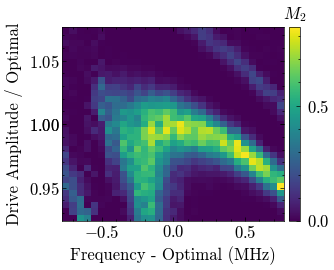

25011900008_eggf_pipi_gain_sweep_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_sweep_25011900008_eggf_pipi_gain_sweep_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\pipi_sweep_25011900008_eggf_pipi_gain_sweep_Q31.svg


In [354]:
pp_sweep = meas.Experiment(config_file=config_path)
data, attrs = prev_data(os.path.join(expt_path, pp_sweep_path+'.h5'))
pp_sweep.data = data
print(data.keys())
cfg = AttrDict(attrs["config"])

qA, qB = pp_sweep_path[-2:]
qA = int(qA)
qB = int(qB)
opt_gain = cfg.device.qubit.pulses.pi_EgGf_Q.half_gain[qA]
opt_freq = cfg.device.qubit.f_EgGf_Q_half[qA]

cycle_sweep = data["cycle_sweep"]
label = "($X_{\pi}, X_{-\pi})^N$"
# label = "($X_{\pi/2}, X_{\pi/2}, X_{-\pi/2}, X_{-\pi/2})^N$"

inner_sweep = data["freq_sweep"]
outer_sweep = data["gain_sweep"]

y_sweep = outer_sweep
x_sweep = inner_sweep

x_sweep -= opt_freq
y_sweep /= opt_gain

labelsize = 12

fig = plt.figure(figsize=(2.5*1.3, 2.0*1.3))
data_name = "products"
plot_data = data[data_name][0] * data[data_name][1]

a0 = plt.subplot(111)
a0.set_ylabel(f"Drive Amplitude / Optimal", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
plt.xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a0.set_xticks([-0.5, 0, 0.5])
ymin = np.min(y_sweep)
ymax = np.max(y_sweep)
ytick_spacing = 0.05
ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
a0.set_yticks(ytick_labels)

divider = make_axes_locatable(a0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.ax.set_title("$M_2$", size=labelsize)

plt.tight_layout(pad=0.0)
plt.show()

filepaths_str = folder[5:] + pp_sweep_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_sweep_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'pipi_sweep_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    
    

# Product of pi/-pi and pi/pi

In [326]:
def calculate_gain_freq_tuples(qubits, pipi_data, piminuspi_data, opt_len, interpolate=True, plot=True, test_pi_half=True):
    if interpolate:
        pipi_freq_sweep, pipi_gain_sweep = pipi_data["freq_sweep"], pipi_data["gain_sweep"]
        piminuspi_freq_sweep, piminuspi_gain_sweep = piminuspi_data["freq_sweep"], piminuspi_data["gain_sweep"]
        reduced_freq_sweep = np.linspace(np.max([pipi_freq_sweep[0], piminuspi_freq_sweep[0]]), np.min([pipi_freq_sweep[-1], piminuspi_freq_sweep[-1]]), 20)
        reduced_gain_sweep = np.linspace(np.max([pipi_gain_sweep[0], piminuspi_gain_sweep[0]]), np.min([pipi_gain_sweep[-1], piminuspi_gain_sweep[-1]]), 25)
        reduced_y = reduced_gain_sweep
        reduced_x = reduced_freq_sweep
        
        print("reduced gain range", reduced_gain_sweep[0], "to", reduced_gain_sweep[-1])
        print("reduced freq range", reduced_freq_sweep[0], "to", reduced_freq_sweep[-1])

        fine_pipi_data = np.zeros((2, len(reduced_y), len(reduced_x)))
        fine_piminuspi_data = np.zeros((2, len(reduced_y), len(reduced_x)))
        for iq in range (2):
            y, x = pipi_gain_sweep, pipi_freq_sweep
            pipi_interp = sp.interpolate.RegularGridInterpolator((y, x), pipi_data["products"][iq], bounds_error=False, fill_value=0)

            y, x = piminuspi_gain_sweep, piminuspi_freq_sweep
            piminuspi_interp = sp.interpolate.RegularGridInterpolator((y, x), piminuspi_data["products"][iq], bounds_error=False, fill_value=0)

            yg, xg = np.meshgrid(reduced_y, reduced_x, indexing='ij')
            fine_pipi_data[iq] = pipi_interp((yg, xg))
            fine_piminuspi_data[iq] = piminuspi_interp((yg, xg))

    else:
        assert np.all([pipi_data["freq_sweep"][i] == piminuspi_data["freq_sweep"][i] for i in range(len(pipi_data["freq_sweep"]))])
        assert np.all([pipi_data["gain_sweep"][i] == piminuspi_data["gain_sweep"][i] for i in range(len(pipi_data["gain_sweep"]))])
        assert len(pipi_data["freq_sweep"]) == len(piminuspi_data["freq_sweep"])
        assert len(pipi_data["gain_sweep"]) == len(piminuspi_data["gain_sweep"])
        fine_pipi_data = pipi_data["products"]
        fine_piminuspi_data = piminuspi_data["products"]
        reduced_x = pipi_data["freq_sweep"]
        reduced_y = pipi_data["gain_sweep"]

    x_sweep = reduced_x
    y_sweep = reduced_y

    prod_of_prods_data_q = np.array([fine_piminuspi_data[i] * fine_pipi_data[i] for i in range(2)])

    qA, qB = qubits

    # Interpolated pi pi data
    label_pipi = "($X_{\pi}, X_{\pi})^N$"
    if test_pi_half:
        label_pipi = "($X_{\pi/2}, X_{\pi/2})^{2N}$"
    title = (
        f"Interpolated Q{qA}/Q{qB} Product of Ns for {label_pipi}\n Len {opt_len:.3f}, Ns={pipi_data['cycle_sweep'].tolist()}"
    )

    if plot:
        plt.figure(figsize=(8, 9))
        plt.suptitle(title, fontsize=20)

        ax_qA = plt.subplot(211, title=f"QA ({qA})")
        ax_qA.set_ylabel(f"Gain", fontsize=18)
        ax_qA.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_pipi_data[0]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        ax_qB = plt.subplot(212, title=f"QB ({qB})")
        ax_qB.set_ylabel(f"Gain", fontsize=18)
        ax_qB.set_xlabel("Frequency [MHz]", fontsize=18)
        ax_qB.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_pipi_data[1]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        plt.tight_layout()
        plt.show()

        # Interpolated pi -pi data
        label_piminuspi = "($X_{\pi}, X_{-\pi})^N$"
        if test_pi_half:
            # label_piminuspi = "($X_{\pi/2}, X_{-\pi/2})^{N}$"
            label_piminuspi = "($X_{\pi/2}, X_{\pi/2}, X_{-\pi/2}, X_{-\pi/2})^N$"
        title = (
            f"Interpolated Q{qA}/Q{qB} Product of Ns for {label_piminuspi}\n Len {opt_len:.3f}, Ns={piminuspi_data['cycle_sweep'].tolist()}"
        )

        plt.figure(figsize=(8, 9))
        plt.suptitle(title, fontsize=20)

        ax_qA = plt.subplot(211, title=f"QA ({qA})")
        ax_qA.set_ylabel(f"Gain", fontsize=18)
        ax_qA.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_piminuspi_data[0]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        ax_qB = plt.subplot(212, title=f"QB ({qB})")
        ax_qB.set_ylabel(f"Gain", fontsize=18)
        ax_qB.set_xlabel("Frequency [MHz]", fontsize=18)
        ax_qB.tick_params(axis="both", which="major", labelsize=16)
        plot_data = fine_piminuspi_data[1]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        plt.tight_layout()
        plt.show()

        # Product of the two inteprolated data sets
        title = (
            f"Interpolated Q{qA}/Q{qB} Product {label_piminuspi} $\\times$ {label_pipi}\n Len {opt_len:.3f}"
        )

        plt.figure(figsize=(8, 9))
        plt.suptitle(title, fontsize=20)

        ax_qA = plt.subplot(211, title=f"QA ({qA})")
        ax_qA.set_ylabel(f"Gain", fontsize=18)
        ax_qA.tick_params(axis="both", which="major", labelsize=16)
        plot_data = prod_of_prods_data_q[0]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)
    
        ax_qB = plt.subplot(212, title=f"QB ({qB})")
        ax_qB.set_ylabel(f"Gain", fontsize=18)
        ax_qB.set_xlabel("Frequency [MHz]", fontsize=18)
        ax_qB.tick_params(axis="both", which="major", labelsize=16)
        plot_data = prod_of_prods_data_q[1]
        plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=18)

        plt.tight_layout()
        plt.show()

    return np.prod(prod_of_prods_data_q, axis=0), x_sweep, y_sweep

In [327]:
from skimage.feature import blob_dog, blob_log, blob_doh
from matplotlib.patches import Ellipse

def find_blobs(data_2d, x_sweep, y_sweep):
    data_2d = (np.copy(data_2d) - np.min(data_2d))/(np.max(data_2d) - np.min(data_2d))
    blobs_log = blob_log(data_2d, max_sigma=5, min_sigma=3, num_sigma=10, threshold=0.1, exclude_border=True)

    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

    blobs_dog = blob_dog(data_2d, max_sigma=5, min_sigma=3, threshold=0.1, exclude_border=True)
    blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

    blobs_doh = blob_doh(data_2d, max_sigma=5, min_sigma=3, threshold=0.01)

    blobs_list = [blobs_log, blobs_dog, blobs_doh]
    colors = ['yellow', 'lime', 'red']
    titles = ['Laplacian of Gaussian', 'Difference of Gaussian', 'Determinant of Hessian']
    sequence = zip(blobs_list, colors, titles)

    idxy = np.argmax(data_2d)
    i_ymax, i_xmax = np.unravel_index(idxy, data_2d.shape)
    x_max = x_sweep[i_xmax]
    y_max = y_sweep[i_ymax]

    fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for idx, (blobs, color, title) in enumerate(sequence):
        ax[idx].set_title(title)
        # ax[idx].imshow(data_2d)
        plt.sca(ax[idx])
        plt.pcolormesh(x_sweep, y_sweep, data_2d, cmap="viridis", shading="auto")
        for blob in blobs:
            r, c, sigma = blob
            opt_freq = x_sweep[int(c)]
            opt_gain = y_sweep[int(r)]
            sigma_x = sigma * (x_sweep[1] - x_sweep[0])
            sigma_y = sigma * (y_sweep[1] - y_sweep[0])
            c = Ellipse((opt_freq, opt_gain), width=sigma_x, height=sigma_y, color=color, linewidth=2, fill=False)
            ax[idx].add_patch(c)
        plt.plot(x_max, y_max, "o", markersize=8, markeredgecolor="r", markerfacecolor="None")
        plt.colorbar()
        # ax[idx].set_axis_off()

    plt.tight_layout()
    plt.show()

    # return blobs_list
    return blobs_log


reduced gain range 0.9263839811542992 to 1.073616018845701
reduced freq range -0.5 to 0.5


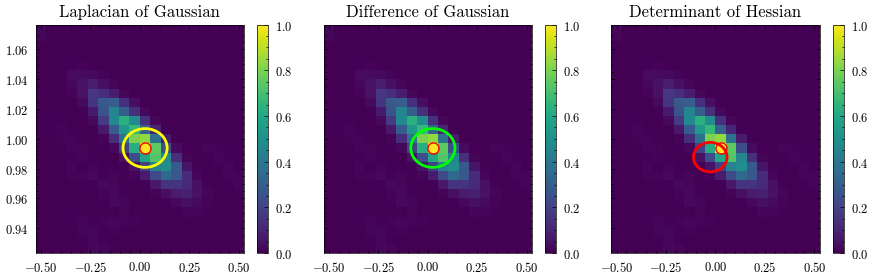

best freq from max 0.02631578947368418
best gain from max 0.9938653317628583
num blobs found 1
best freq from blob 0.02631578947368418
best gain from blob 0.9938653317628583


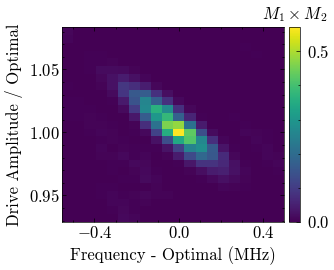

25011900008_eggf_pipi_gain_sweep_Q31
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\ppXpmp_sweep_25011900008_eggf_pipi_gain_sweep_Q31.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\ppXpmp_sweep_25011900008_eggf_pipi_gain_sweep_Q31.svg


In [355]:
pipi_data = pp_sweep.data
piminuspi_data = pmp_sweep.data

prod_of_prods_data, x_sweep, y_sweep = calculate_gain_freq_tuples([qA, qB], pipi_data, piminuspi_data, opt_len=0, interpolate=True, plot=False)
blobs = find_blobs(prod_of_prods_data, x_sweep=x_sweep, y_sweep=y_sweep)

idxy = np.argmax(prod_of_prods_data)
ymax, xmax = np.unravel_index(idxy, prod_of_prods_data.shape)
pi_freq_max = x_sweep[xmax]
pi_gain_max = y_sweep[ymax]
print("best freq from max", pi_freq_max)
print("best gain from max", pi_gain_max)

print("num blobs found", len(blobs))
if len(blobs) > 0:
    r, c, sigma = blobs[0]
    pi_freq_blob = x_sweep[int(c)]
    pi_gain_blob = y_sweep[int(r)]
    sigma_x = sigma * (x_sweep[1] - x_sweep[0])
    sigma_y = sigma * (y_sweep[1] - y_sweep[0])
    print("best freq from blob", pi_freq_blob)
    print("best gain from blob", pi_gain_blob)

if len(blobs) == 0:
    print("WARNING: no blobs found!")
elif np.abs(pi_freq_max - pi_freq_blob) > 2*sigma_x or np.abs(pi_gain_max - pi_gain_blob) > 2*sigma_y:
    print('WARNING: max product location is not close to found blob center!')


opt_freq = pi_freq_blob
opt_gain = pi_gain_blob
# opt_freq = pi_freq_max
# opt_gain = pi_gain_max

x_sweep -= opt_freq
y_sweep /= opt_gain

labelsize = 12

fig = plt.figure(figsize=(2.5*1.3, 2.0*1.3))
plot_data = prod_of_prods_data

a0 = plt.subplot(111)
a0.set_ylabel("Drive Amplitude / Optimal", fontsize=labelsize)
a0.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.pcolormesh(x_sweep, y_sweep, plot_data, cmap="viridis", shading="auto")
plt.xlabel("Frequency - Optimal (MHz)", fontsize=labelsize)
a0.set_xticks([-0.4, 0, 0.4])
# ymin = np.min(y_sweep)
# ymax = np.max(y_sweep)
# ytick_spacing = 0.05
# ytick_labels = np.round(np.linspace(ymin, ymax, int(np.ceil((ymax-ymin)/ytick_spacing))+1) /ytick_spacing) * ytick_spacing
a0.set_yticks([0.95, 1.0, 1.05])

divider = make_axes_locatable(a0)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(cax=cax, ticks=[0, 0.5, 1])
cbar.ax.tick_params(labelsize=labelsize)
cbar.ax.set_title("$M_1 \\times M_2$", size=labelsize)

plt.tight_layout(pad=0.0)
plt.show()

filepaths_str = folder[5:] + pp_sweep_path

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'ppXpmp_sweep_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'ppXpmp_sweep_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)
    
    

# CSWAP leakage

In [292]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
folder = 'data_250119'
expt_path = os.path.join(data_path, 'data', folder)
print('Data dir', expt_path)

Data dir S:\QRAM\qram_4QR2\data\data_250119


In [642]:
leakage_21_paths = [
    "00002_leakage_EgGf_qubit21",
    "00003_leakage_EgGf_qubit21",
    "00004_leakage_EgGf_qubit21",
    "00005_leakage_EgGf_qubit21",
    "00011_leakage_EgGf_qubit21",
    "00012_leakage_EgGf_qubit21",
    "00013_leakage_EgGf_qubit21",
]

leakage_31_paths = [
    "00006_leakage_EgGf_qubit31",
    "00007_leakage_EgGf_qubit31",
    "00008_leakage_EgGf_qubit31",
    "00009_leakage_EgGf_qubit31",
    "00019_leakage_EgGf_qubit31",
    "00010_leakage_EgGf_qubit31",
]

In [643]:
data_21 = []
leakage_lens_21 = []

for leakage_path in leakage_21_paths:
    print("Processing", leakage_path)
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_path+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    leakage_lens_21.append(rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[2])
    data_21.append(data)

Processing 00002_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00002_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1939458940.py: 13

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00003_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00003_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00004_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00004_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00005_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00005_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00011_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00011_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00012_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00012_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00013_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00013_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [606]:
data_31 = []
leakage_lens_31 = []
for leakage_path in leakage_31_paths:
    print("Processing", leakage_path)
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_path+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    leakage_lens_31.append(rbprog.cfg.device.qubit.pulses.pi_EgGf_Q.half_sigma[3])
    data_31.append(data)

Processing 00006_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00006_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1939458940.py: 13

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00007_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00007_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00008_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00008_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00009_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00009_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00019_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00019_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00010_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00010_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [644]:
def get_bad(qDrive):
    if qDrive == 2: return "e"
    if qDrive == 3: return "g"
    return None

def get_good(qDrive):
    if qDrive == 3: return "e"
    if qDrive == 2: return "g"
    return None

In [645]:
pop_Bgf_21 = []
depths_21 = []
# print(data_21[0].keys())
for data in data_21:
    # pop_Bgf_21.append(data["popln_Bgf_avg"])
    pop_Bgf_21.append(data["popln_Bgf_avg"]+ data["popln_Bge_avg"])
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_21.append(unique_depths)

pop_Bgf_31 = []
depths_31 = []
for data in data_31:
    # pop_Bgf_31.append(data["popln_Bgf_avg"])
    pop_Bgf_31.append(data["popln_Bgf_avg"] + data["popln_Bge_avg"])
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_31.append(unique_depths)

Plotting the wrong state minima to highlight the ones we are using

In [646]:
theory_dir = "S:\QRAM\qram_4QR2\plots\paper\supmat"
theory_q2_path = "theory_pop_q2_wrongstate"
theory_q3_path = "theory_pop_q3_wrongstate"

data_theory_q2 = dict()
with np.load(os.path.join(theory_dir, theory_q2_path+".npz")) as file:
    for key in file.keys():
        data_theory_q2[key] = file[key]
data_theory_q3 = dict()
with np.load(os.path.join(theory_dir, theory_q3_path+".npz")) as file:
    for key in file.keys():
        data_theory_q3[key] = file[key]

In [647]:
t_vec_12 = data_theory_q2['t_vec_12']
t_vec_13 = data_theory_q3['t_vec_13']
pop_q2 = data_theory_q2['pop_q2']
pop_q3 = data_theory_q3['pop_q3']
amp_vec_12 = data_theory_q2['amp_vec_12']
amp_vec_13 = data_theory_q3['amp_vec_13']
w_vec_12 = data_theory_q2['w_vec_12']
w_vec_13 = data_theory_q3['w_vec_13']

len_q1q3 = np.array([0.41423002407926174, 0.34269455421503864, 0.29110476429984883, 0.24874669628911195, 0.2199548983178091, 0.2020861425417043, 0.18250152594941127, 0.1676613742325565, 0.15357097763287902, 0.1418394586635039, 0.13117702458358807, 0.12178942465536591, 0.11578401043424631, 0.11075848248788242, 0.10448723704560985, 0.09951109117360128, 0.09664469008168952, 0.09064274972329202, 0.08628864072542938, 0.08199132287522362, 0.07931563419005563, 0.07581421284827643, 0.07386521467198023, 0.069959016045751, 0.06889146706335908, 0.06835413640748393, 0.06446941297141699, 0.06223220891067346, 0.06064569351718567, 0.058670697089451156])
freq_q1q3 = np.array([5142.368818005041, 5142.200345806339, 5141.9564793659065, 5141.697539652303, 5141.407972650505, 5141.064440049666, 5140.697574046106, 5140.330040741174, 5139.843429992427, 5139.392529235084, 5138.905333948207, 5138.33833801746, 5137.783555801703, 5137.109798888519, 5136.476127532039, 5135.848148881454, 5135.039412449819, 5134.3543596999425, 5133.570705645279, 5132.701335536354, 5131.796993407784, 5130.97652689619, 5130.0559769829715, 5129.114172858743, 5128.04872429693, 5127.019279680188, 5126.011590712254, 5124.958317604664, 5123.87207987953, 5122.738473714098])
all_epop_reshaped_q1q3 = np.array([[0.06497742151724446, 0.06585549435127656, 0.0696186655151553, 0.08103361846105395, 0.05117912701208434, 0.08053186153898224, 0.09683893630289658, 0.0768941294530879, 0.05995986010467004, 0.067737079882346, 0.10060210801009259, 0.1294530858003283, 0.1302057208144964, 0.16018564978061198, 0.17385850512750772, 0.16683391918336596, 0.13283993979112624, 0.15253386886884943, 0.13973908684394584, 0.12004515806468324, 0.09508279049618079, 0.085800301067465, 0.08153537423605511, 0.0770195689822561, 0.06610637280750548, 0.06472654302883449, 0.05770195685724347, 0.054189663826853945, 0.05368790768047654, 0.0630958354248765], [0.0444500575157708, 0.04621795709117446, 0.05493117892527914, 0.06490718604343079, 0.03283242834081408, 0.06515974317325729, 0.07475691429691196, 0.05733047105816965, 0.04141937115559657, 0.044197500433708924, 0.07336784948187278, 0.09710822152644186, 0.11908069279908359, 0.15166056321515345, 0.1459780279354007, 0.15355474176448908, 0.12615229274475978, 0.1319611062137151, 0.1289304206883018, 0.09963379240348744, 0.08397525018066018, 0.08511175732006145, 0.0765248140907054, 0.05038515018482, 0.03788357115989481, 0.051269099640664006, 0.048743528223711155, 0.04861724965294898, 0.03561055689108433, 0.035231721959688864], [0.04635587659324268, 0.05173998686940823, 0.06198292947077423, 0.06526592252181646, 0.04714379514902053, 0.08194353349534983, 0.09954038177094622, 0.07380170801853454, 0.048063033498260146, 0.045042679174499056, 0.08443860802445907, 0.1126723582241913, 0.13013788665343035, 0.16073539068442586, 0.15771503612798177, 0.15797767667452542, 0.1364412347544076, 0.15692711753234928, 0.15167432802617903, 0.12002626395278501, 0.08982271834454157, 0.10426789232278494, 0.09179251477923396, 0.07078135290988663, 0.06158896914153137, 0.06434668419604885, 0.06198292947077423, 0.05187130728622845, 0.057912016042761257, 0.04333552295395244], [0.0453943889295369, 0.05677607267186746, 0.04486500864487836, 0.05015881495000358, 0.04407093770973884, 0.051746956325999405, 0.059158285383259845, 0.05412916903484709, 0.04407093770973884, 0.04949708873900345, 0.07887771313789506, 0.09555320278034278, 0.1352567496048947, 0.14107993652050396, 0.17787189045783014, 0.16000529380667877, 0.1344626788316915, 0.14253573319219276, 0.13631551116194546, 0.10296453152914774, 0.07662784542410238, 0.0927739552510586, 0.06551085312740874, 0.06021704607438177, 0.04327686611063714, 0.06723134023734499, 0.030307041334704278, 0.04420328260764217, 0.035468502760644186, 0.03083642138730744], [0.03978370081655345, 0.04377494528906341, 0.04647869257607865, 0.054718681601708404, 0.05935367581231917, 0.07982490096584607, 0.08098364951169931, 0.05072743733760831, 0.04866743956767674, 0.05008368814228637, 0.0705549124939232, 0.1078923655390083, 0.12282734647996982, 0.16183854820074933, 0.1454873187350294, 0.16557229309547655, 0.13441483201546275, 0.1524398094773585, 0.12179734843900497, 0.10093987418185531, 0.10995236259410963, 0.10209862237672457, 0.05935367581231917, 0.058194927288798624, 0.05085618689216144, 0.05613493026025063, 0.05317368353489125, 0.056263680373553115, 0.046349942069922545, 0.04776619030339031], [0.041936319565434386, 0.05371472952259666, 0.061869013806507125, 0.06381051047061868, 0.043360083216516694, 0.07856588144282733, 0.08723789803325, 0.051773233241038885, 0.046207611442677245, 0.05229096645414494, 0.061869013806507125, 0.10704116026379348, 0.128138752811431, 0.1317628786182509, 0.15053067581422536, 0.1532487709572608, 0.1404348955328982, 0.14276469150889518, 0.1229614293424479, 0.10535853033907884, 0.09345068671510763, 0.08180170888767975, 0.06950556562509197, 0.05772715506298526, 0.04206575288261194, 0.05306756490116866, 0.03895935830482361, 0.05345586400367646, 0.06277504614622448, 0.048537406188956043], [0.055392844226434215, 0.06583471284859442, 0.06507067434786529, 0.0637972749271169, 0.06456131415860651, 0.07844136012317562, 0.08633643266821202, 0.0649433343993553, 0.05806698136447139, 0.05984973897373211, 0.0694002294442335, 0.10594677202224922, 0.14223863565749564, 0.17025340686295687, 0.17127212530460378, 0.15153444614574554, 0.1209728772630416, 0.14249331465794443, 0.13472558259533604, 0.10823888959653567, 0.08901056920924427, 0.08264357570363362, 0.08531771370764873, 0.07780466063926696, 0.07080096800813682, 0.07805934111155194, 0.06710811155078579, 0.04698841264130944, 0.04953521013679825, 0.06532535390670513], [0.04909766467499421, 0.06236730369299501, 0.049230360947909876, 0.07006369472424774, 0.059315286672014744, 0.08545647662702975, 0.08359872682389043, 0.05281316365993866, 0.047770701190994934, 0.05015923652326154, 0.07430997883184853, 0.1238057329197256, 0.13349256976519594, 0.1571125265850578, 0.15830679405729794, 0.17210721868404505, 0.13097133758462134, 0.14317940552017322, 0.12845010620880323, 0.09036624238782706, 0.07762738957852156, 0.0963375806681089, 0.07921974538103269, 0.056794055255513246, 0.054007431344683214, 0.06886942678747694, 0.045382166654262986, 0.0541401284389958, 0.055865181512702256, 0.05745753736107745], [0.047714247639175526, 0.05917632991748179, 0.04971344795415606, 0.0549113687877329, 0.04264960775153066, 0.05824337021405723, 0.0770358523674721, 0.04824736774595545, 0.04624816740280828, 0.05357856950224291, 0.0726376122766279, 0.11941889990787288, 0.12848194142638308, 0.14554178328907452, 0.1662001867558979, 0.14727442394836443, 0.13407970167935174, 0.14141010262562032, 0.11808609944473435, 0.09516193597987765, 0.08463281392964005, 0.08449953440247579, 0.07743569241105126, 0.057843529262423934, 0.03558576661968353, 0.04291616778937862, 0.039984006435039895, 0.04105024718202672, 0.038517926916552724, 0.04171664715658861], [0.04971736913248667, 0.058838644141336084, 0.05614080205439326, 0.0698869476630591, 0.05125899328470429, 0.07952209681595059, 0.09493833579275643, 0.0698869476630591, 0.0429085303247387, 0.06410585894472431, 0.07297019527410777, 0.09249743090440339, 0.125513874632454, 0.15621788299437198, 0.17381808847414676, 0.16071428571572932, 0.13424974342411625, 0.159558067837288, 0.1357913676811992, 0.1070143892585794, 0.08581706063743705, 0.07566803703700217, 0.0677029806414034, 0.06487667009488862, 0.04380781146515742, 0.057168550873914266, 0.04560637222368477, 0.054984584467568764, 0.055369989723453375, 0.056012333744280246]])
e_pop_avg_q1q3 = np.average(all_epop_reshaped_q1q3, axis=0)
e_pop_std_q1q3 = np.std(all_epop_reshaped_q1q3, axis=0)


len_q1q2 = np.array([0.364086746702782, 0.33499695249444006, 0.3115565075107539, 0.2847969576602822, 0.25284893507428347, 0.236859238200425, 0.22816247678777374, 0.21303094516365295, 0.20045736351450583, 0.18541736446454135, 0.1709991708583613, 0.16538139362244123, 0.16282358092837007, 0.15354314952859763, 0.1497495655547218, 0.14362281211350916, 0.14189858874248545, 0.1362482863356786, 0.129222931492836, 0.1314461465660465, 0.12086730909533677, 0.11748195599716706, 0.11601739092390609, 0.11825654712422978, 0.11422609643608995, 0.10968623408981701, 0.10530639384176958, 0.10742513040045533, 0.10370289392527689, 0.1027131236571057])
freq_q1q2 = np.array([5885.353553866747, 5885.223252450096, 5885.029323441599, 5884.859248926712, 5884.63362541482, 5884.404594077928, 5884.157681474703, 5883.9369779082845, 5883.673345368545, 5883.2472051629375, 5882.977221784642, 5882.704061478638, 5882.583278840646, 5882.301053697849, 5882.00224539555, 5881.690881121004, 5881.39458104978, 5881.113557867901, 5880.7757657449265, 5880.472766035981, 5880.174349198405, 5879.874720853163, 5879.584775165393, 5879.262464274851, 5878.966490972429, 5878.627271668853, 5878.3378207386695, 5878.067311529557, 5877.595637812794, 5877.302884693251])
all_epop_reshaped_q1q2 = np.array([[0.08332301627396135, 0.0628946393868922, 0.07762783241933285, 0.08332301627396135, 0.09322768367375392, 0.0770087904040902, 0.08530394948626135, 0.07465643193551595, 0.09310387520426784, 0.11910362788798104, 0.15636993963729953, 0.1760554661506186, 0.16528414043111453, 0.18472205056946195, 0.1827411170470007, 0.1951219512196178, 0.1940076761234066, 0.16887458243818276, 0.16478890681532982, 0.19896001020807363, 0.159093722930091, 0.1573604063948535, 0.13854153769971056, 0.1373034542730015, 0.14857001361901812, 0.11204655193819506, 0.13457967067404117, 0.11501795250686864, 0.12876067877218195, 0.14089389655203102], [0.08098807916582339, 0.0667322113668524, 0.0613248129074227, 0.08528941904671433, 0.08651837333245953, 0.09241735311827415, 0.07459751796672293, 0.07041907343029441, 0.07361435466328159, 0.09598132001577649, 0.15165294382406652, 0.16406538053325925, 0.16603170749431953, 0.1863094511324787, 0.18815288237092193, 0.17488017744800718, 0.1874155095126062, 0.1684896158162223, 0.15964114585195033, 0.17610913113082263, 0.14698291753717702, 0.13174388643191917, 0.1291630823388445, 0.1480889767599785, 0.1429273692777054, 0.10507558068084055, 0.09696448370349421, 0.11797959936788925, 0.13297284011306384, 0.1342017945381539], [0.07306273097843008, 0.06285362895754847, 0.05190651948648412, 0.07121771241660406, 0.08253382533919806, 0.08696186995074628, 0.07539975441902293, 0.06900369045357695, 0.06912669168845752, 0.08400984038695385, 0.13960639648536363, 0.158917589586505, 0.16642066427307525, 0.1821648216484267, 0.17699877040768638, 0.1915129154939429, 0.18708487086016318, 0.1666666666802185, 0.14341943460330717, 0.1897908983067057, 0.15153751539585444, 0.14452644559659553, 0.11672816728506713, 0.16334563387745518, 0.14538745387455726, 0.12066420701118637, 0.11783517877317971, 0.11943419458255394, 0.12878228824127444, 0.14415744199441483], [0.08934169296061868, 0.08379551500060145, 0.0725825898243123, 0.08958283112403448, 0.09078852193486527, 0.08331323850099506, 0.09983120345014379, 0.08476006763425403, 0.0851217748903259, 0.09464673274844516, 0.15529298304983186, 0.16023631557939286, 0.17169037874038492, 0.18483240906419993, 0.1778394020298037, 0.1936339523587199, 0.18929346515561932, 0.17301663870451783, 0.16132143735404328, 0.17012298047893293, 0.14829997605684203, 0.15420786110441548, 0.12599469513089107, 0.1502290814294579, 0.13732818922291132, 0.11538461555527742, 0.13021461304965282, 0.1200868098834495, 0.14335664352716512, 0.15155534136349552], [0.06478384740526043, 0.05735166604754112, 0.049176266731924816, 0.07246376813184281, 0.07605598910894625, 0.06763285038017627, 0.06961476564371204, 0.050167224080551596, 0.07382633469595033, 0.08732813127254675, 0.13117800074346006, 0.1532268058683329, 0.1576861144364606, 0.1667286019790872, 0.17292208600947706, 0.16202155332590237, 0.18295553078248816, 0.15780998426902393, 0.1378669644218212, 0.1542177633371383, 0.12758577996428594, 0.11817168385618315, 0.12139229531851783, 0.1356373097977609, 0.12622321362395988, 0.10231636365013727, 0.09463644246469861, 0.10330732073287385, 0.11693298670229729, 0.136628267332732], [0.0684693624469011, 0.0628876214383619, 0.05432895063260763, 0.05879434434143218, 0.07640783962638917, 0.06040684742260549, 0.06536839532848697, 0.06115107955692343, 0.056561647240540226, 0.09216075462890021, 0.13929546068989293, 0.1701810965922623, 0.14835028549120663, 0.17650707022517612, 0.1747705284069305, 0.17340610277912857, 0.17340610277912857, 0.15194740805288326, 0.13371371868132864, 0.164227239401797, 0.12093773257321204, 0.11895311383302853, 0.11039444341147586, 0.12577524188201594, 0.12118581035588848, 0.0943934511514833, 0.09947903765297975, 0.10121557974914797, 0.10741751476796231, 0.12106177129899247], [0.07264541287750798, 0.06218057956803719, 0.0734972016758634, 0.08201508883053903, 0.09296665870912692, 0.08627403301001056, 0.08724750588804936, 0.07240204470641867, 0.06741299588546852, 0.10294475582787252, 0.15709418365193237, 0.15648576337275494, 0.16293502069122218, 0.1887320520074622, 0.19724993915795305, 0.19177415470689813, 0.1946945733011843, 0.1746166954048784, 0.1622049161238442, 0.16901922609345774, 0.1360428332191767, 0.135556096787199, 0.13932830413606012, 0.14334387970257628, 0.13348746653803725, 0.11401800938164107, 0.12387442241383569, 0.10282307171927851, 0.11998053095315754, 0.12922852284182115], [0.07084402150123464, 0.0682789793557354, 0.06705753070645769, 0.07267619442504346, 0.08550140515032222, 0.0798827413033021, 0.07560767118627505, 0.05178942225836025, 0.06534750213790304, 0.08770001222054366, 0.1232441680744984, 0.16257481378746708, 0.16037620656458507, 0.17930866056249292, 0.16819347795646633, 0.16196408975520915, 0.18969097349526048, 0.1637962623673364, 0.14132160753499187, 0.1655062909124697, 0.13081714921443172, 0.13093929449322186, 0.11664834493937933, 0.13655795816438804, 0.13606937877413394, 0.10223525128521398, 0.10504458336731669, 0.09246366239152935, 0.12544277530498177, 0.1234884577952049], [0.07018186256778769, 0.06139387283791087, 0.07005980752431398, 0.08482851251645121, 0.08946661784565152, 0.08202123800674423, 0.0627364823639703, 0.06139387283791087, 0.07506407943693644, 0.09495911180846402, 0.15220310033984538, 0.16514097436236466, 0.16135725656607805, 0.18625656055655357, 0.17624801695670184, 0.15879409288991397, 0.18552422837137117, 0.15610887345475552, 0.14695471776790717, 0.17026730137035967, 0.1424386675105299, 0.13340656695314393, 0.13438301025609187, 0.14134016843647174, 0.14158427963470685, 0.1118027587468981, 0.11473208873764308, 0.10228243626786332, 0.11387770073828021, 0.13365067774834466], [0.07736635640329928, 0.05627758718373426, 0.06866110866025883, 0.06522805330554966, 0.07344286449654257, 0.07601765572083635, 0.06400196174598967, 0.0627758708737267, 0.07368808241332875, 0.09845512538290078, 0.1465179009355379, 0.16208925958626214, 0.15779794016674842, 0.18244237373200595, 0.19163805821060115, 0.16319274188466337, 0.17778322741980812, 0.16147621413740368, 0.1580431584111563, 0.16539970606992294, 0.13965179030171887, 0.13658656237463276, 0.11721432109432302, 0.1391613539254287, 0.1297204512051891, 0.10053948023861331, 0.10593428185935522, 0.10152035313323489, 0.12187346747806237, 0.11463952918169103]])
e_pop_avg_q1q2 = np.average(all_epop_reshaped_q1q2, axis=0)
e_pop_std_q1q2 = np.std(all_epop_reshaped_q1q2, axis=0)


q2/q1 pi/2 length 0.236859238200425
q2/q1 pi/2 length 0.22816247678777374
q2/q1 pi/2 length 0.21303094516365295
q2/q1 pi/2 length 0.195
q2/q1 pi/2 length 0.185
q2/q1 pi/2 length 0.175
q3/q1 pi/2 length 0.18250152594941127
q3/q1 pi/2 length 0.1676613742325565
q3/q1 pi/2 length 0.15357097763287902
q3/q1 pi/2 length 0.1418394586635039
q3/q1 pi/2 length 0.137
q3/q1 pi/2 length 0.13117702458358807


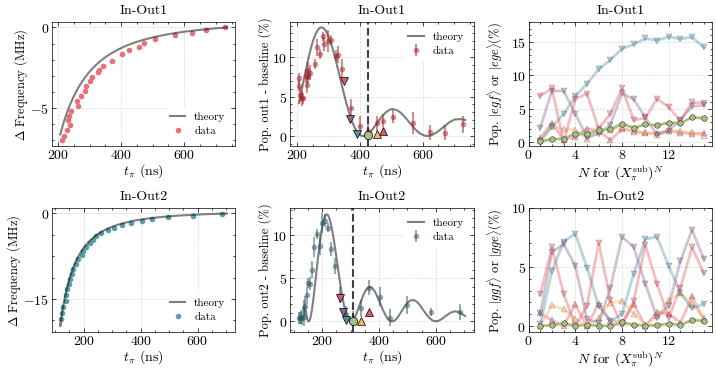

250119_00006_00007_00008_00009_00019_00010_31_00002_00003_00004_00005_00011_00012_00013_21
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\swap_minima_calib_250119_00006_00007_00008_00009_00019_00010_31_00002_00003_00004_00005_00011_00012_00013_21.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\swap_minima_calib_250119_00006_00007_00008_00009_00019_00010_31_00002_00003_00004_00005_00011_00012_00013_21.svg


In [659]:
labelsize = 10
keep_lens_21 = [0, 1, 2, 4, 5, 6]
keep_lens_31 = [0, 1, 2, 3, 4, 5] #, 5, 6]
good_ilen_21 = 2
good_ilen_31 = 2

opt_len_12 = 0.2130
opt_len_13 = 0.1536

color_cycle = ['#e15b64', '#fbb26d', '#abbd83', '#5296a5', '#8d6b94']

color_cycle_21 = color_cycle
# start_color = "#f9dcdf"
# mid_color = "#e15b64"
# end_color = "#f9dcdf"
# color_cycle_21 = color_gradient(start_hex=start_color, end_hex=mid_color, steps=good_ilen_21 + 1) + color_gradient(start_hex=mid_color, end_hex=end_color, steps=len(keep_lens_21) - good_ilen_21 + 1)[1:]
marker_cycle_21 = ["^"]*(good_ilen_21) + ["o"] + ["v"]*(len(keep_lens_21) - good_ilen_21 - 1)

color_cycle_31 = color_cycle
# start_color = "#d4e7ed"
# mid_color = "#5296a5"
# end_color = "#d4e7ed"
# color_cycle_31 = color_gradient(start_hex=start_color, end_hex=mid_color, steps=good_ilen_31 + 1) + color_gradient(start_hex=mid_color, end_hex=end_color, steps=len(keep_lens_31) - good_ilen_31 + 1)[1:]
marker_cycle_31 = ["^"]*(good_ilen_31) + ["o"] + ["v"]*(len(keep_lens_31) - good_ilen_31 - 1)

color_dict = {'q1q3_right': '#5b9faeff', 'q1q3_wrong': '#2f5760ff', 'q1q2_right': '#e5717aff', 'q1q2_wrong': '#a31f29ff'}

fig, axes = plt.subplots(2, 3, figsize=(8.0, 4.0), sharey=False, gridspec_kw={'width_ratios':[1, 1, 1]})
plt.subplots_adjust(hspace=0.5) 
plt.subplots_adjust(wspace=0.3) 


#==============#
# plot the stark shift check

x12_th = t_vec_12
x12_th_alt = 1/(2*t_vec_12)
y12_th = 1e3*np.array(w_vec_12/2/np.pi)
x12_exp = len_q1q2*1e3*2
y12_exp = freq_q1q2

x13_th = t_vec_13
x13_th_alt = 1/(2*t_vec_13)
y13_th = 1e3*np.array(w_vec_13/2/np.pi)
x13_exp = len_q1q3*1e3*2
y13_exp = freq_q1q3

idx_12_start = np.argmin(np.abs(x12_exp[0] - x12_th))
idx_12_stop = np.argmin(np.abs(x12_exp[-1] - x12_th))

idx_13_start = np.argmin(np.abs(x13_exp[0] - x13_th))
idx_13_stop = np.argmin(np.abs(x13_exp[-1] - x13_th))


ax = axes[0, 0]
plt.sca(ax)
ax.set_title("In-Out1", size=labelsize)
plt.grid(which='major')
ax.plot(x12_th[idx_12_start:idx_12_stop], y12_th[idx_12_start:idx_12_stop] - y12_th[idx_12_start], alpha=0.5, color='black', label='theory', zorder=10)
ax.errorbar(x12_exp[:-3], y12_exp[:-3] - y12_exp[0], fmt='o', color=color_dict['q1q2_right'], label='data')
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_ylabel('$\Delta$ Frequency (MHz)', labelpad=0.3)
ax.set_yticks([-5, 0])
# ax.set_yticks([5880, 5885])
ax.set_xticks([200, 400, 600])
ax.legend()

ax = axes[1, 0]
plt.sca(ax)
ax.set_title("In-Out2", size=labelsize)
plt.grid(which='major')
ax.plot(x13_th[idx_13_start:idx_13_stop], y13_th[idx_13_start:idx_13_stop] - y13_th[idx_13_start], alpha=0.5, color='black', label='theory', zorder=10)
ax.errorbar(x13_exp[1:-1], y13_exp[1:-1] - y13_exp[0], fmt='o', color=color_dict['q1q3_right'], label='data')
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_xticks([200, 400, 600])
ax.set_ylabel('$\Delta$ Frequency (MHz)', labelpad=0.3)
ax.set_yticks([-15, 0])
# ax.set_yticks([5130, 5140])
ax.legend()


#==============#

leakage_pops_21 = []
for i_leak in keep_lens_21:
    leakage_pops_21.append(pop_Bgf_21[i_leak][np.argwhere(depths_21[i_leak] == 1)[0][0]])
    # leakage_pops_21.append(np.max(pop_Bgf_21[i_leak]))
leakage_pops_21 = np.array(leakage_pops_21)
leakage_pops_31 = []
for i_leak in keep_lens_31:
    leakage_pops_31.append(pop_Bgf_31[i_leak][np.argwhere(depths_31[i_leak] == 1)[0][0]])
    # leakage_pops_31.append(np.max(pop_Bgf_31[i_leak]))
leakage_pops_31 = np.array(leakage_pops_31)

#==============#
#  plot the minima experiment

x12_th = t_vec_12
x12_th_alt = 1/(2*t_vec_12)
baseline_12 = 0.06
y12_th = np.array(pop_q2)
x12_exp = len_q1q2*1e3*2
y12_exp = e_pop_avg_q1q2[::-1]
y12_exp = np.array(e_pop_avg_q1q2) - baseline_12
y12_err = e_pop_std_q1q2[::-1]

x13_th = t_vec_13
x13_th_alt = 1/(2*t_vec_13)
baseline_13 = 0.045
y13_th = np.array(pop_q3)
x13_exp = len_q1q3*1e3*2
y13_exp = e_pop_avg_q1q3[::-1]
y13_exp = np.array(e_pop_avg_q1q3) - baseline_13
y13_err = e_pop_std_q1q3[::-1]

idx_12_start = np.argmin(np.abs(x12_exp[0] - x12_th))
idx_12_stop = np.argmin(np.abs(x12_exp[-1] - x12_th))

idx_13_start = np.argmin(np.abs(x13_exp[0] - x13_th))
idx_13_stop = np.argmin(np.abs(x13_exp[-1] - x13_th)) - 40


ax = axes[0, 1]
plt.sca(ax)
ax.set_title("In-Out1", size=labelsize)
plt.grid(which='major')
ax.plot(x12_th[idx_12_start:idx_12_stop], 100*y12_th[idx_12_start:idx_12_stop], alpha=0.5, color='black', label='theory')
# ax.plot(x12_exp, 100*y12_exp, 'o', alpha=0.2, markeredgewidth=0.0, markersize=4, color='k', label='data')
ax.errorbar(x12_exp, 100*y12_exp, 100*y12_err, fmt='o', alpha=0.5, markeredgewidth=0.0, markersize=4, color=color_dict['q1q2_wrong'], label='data')
for i, i_leak in enumerate(keep_lens_21):
    print("q2/q1 pi/2 length", leakage_lens_21[i_leak])
    ax.plot(2*1e3*leakage_lens_21[i_leak], 100*leakage_pops_21[i], marker_cycle_21[i % len(marker_cycle_21)], markeredgewidth=0.5, markeredgecolor='k', markersize=6, color=color_cycle_21[i % len(color_cycle_21)], zorder=10)
ax.axvline(2*1e3*opt_len_12, color='black', linestyle='--', alpha=0.75)
# ax[0, 1].set_xlabel('Time (ns)')
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_ylabel('Pop. out1 - baseline (%)', labelpad=0.3)
ax.set_xticks([200, 400, 600])
ax.legend()

ax = axes[1, 1]
plt.sca(ax)
ax.set_title("In-Out2", size=labelsize)
plt.grid(which='major')
ax.plot(x13_th[idx_13_start:idx_13_stop], 100*y13_th[idx_13_start:idx_13_stop], alpha=0.5, color='black', label='theory')
ax.errorbar(x13_exp[1:], 100*y13_exp[1:], 100*y13_err[1:], fmt='o', alpha=0.5, markeredgewidth=0.0, markersize=4, color=color_dict['q1q3_wrong'], label='data')
# ax.plot(x13_exp[1:], 100*y13_exp[1:], 'o', alpha=0.2, markeredgewidth=0.0, markersize=4, color='k', label='data')
for i, i_leak in enumerate(keep_lens_31):
    print("q3/q1 pi/2 length", leakage_lens_31[i_leak])
    ax.plot(2*1e3*leakage_lens_31[i_leak], 100*leakage_pops_31[i], marker_cycle_31[i % len(marker_cycle_31)], markeredgewidth=0.5, markeredgecolor='k', markersize=6, color=color_cycle_31[i % len(color_cycle_31)], zorder=10)
ax.axvline(2*1e3*opt_len_13, color='black', linestyle='--', alpha=0.75)
ax.set_xlabel('$t_\pi$ (ns)', labelpad=0.3, fontsize=labelsize)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_xticks([200, 400, 600])
ax.set_ylabel('Pop. out2 - baseline (%)', labelpad=0.3)
ax.legend()

#==============#
#  plot the leakage error amp

# print(np.array(pop_Bgf_21).shape)
ax = axes[0, 2]
plt.sca(ax)
plt.grid(which='major')
plt.title("In-Out1", size=labelsize)
for i, i_leak in enumerate(keep_lens_21):
    if i == good_ilen_21:
        zorder = 10
        alpha = 1.0
    else:
        zorder = None
        alpha = 0.4
    plt.plot(depths_21[i_leak][:15], 100*pop_Bgf_21[i_leak][:15], marker_cycle_21[i % len(marker_cycle_21)]+'-',alpha=alpha, markeredgewidth=0.3, markeredgecolor='k', markersize=4, linewidth=2.0, color=color_cycle_21[i % len(color_cycle_21)], zorder=zorder)
plt.ylabel(f"Pop. $|{get_bad(2)}gf\\rangle$ or $|{get_bad(2)}ge\\rangle$(%)")
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(2)}eg\\rangle-|{get_good(2)}gf\\rangle"+"})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax.set_xticks(np.arange(0, 16, 4))
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
plt.ylim(-0.5, 18.0)

# print(np.array(pop_Bgf_31).shape)
ax = axes[1, 2]
plt.sca(ax)
plt.title("In-Out2", size=labelsize)
plt.grid(which='major')
for i, i_leak in enumerate(keep_lens_31):
    if i == good_ilen_31:
        zorder = 10
        alpha = 1.0
    else:
        zorder = None
        alpha = 0.4
    plt.plot(depths_31[i_leak][:15], 100*pop_Bgf_31[i_leak][:15], marker_cycle_31[i % len(marker_cycle_31)]+'-',alpha=alpha, markeredgewidth=0.3, markeredgecolor='k', markersize=4, linewidth=2.0, color=color_cycle_31[i % len(color_cycle_31)], zorder=zorder)
plt.ylabel(f"Pop. $|{get_bad(3)}gf\\rangle$ or $|{get_bad(3)}ge\\rangle$(%)")
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(3)}eg\\rangle-|{get_good(3)}gf\\rangle"+"})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax.tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax.set_xticks(np.arange(0, 16, 4))
plt.ylim(-0.5, 10)



plt.show()

filepaths_str = folder[5:] + "_" + '_'.join([path[:5] for path in leakage_31_paths]) + "_31"
filepaths_str = filepaths_str + "_" + '_'.join([path[:5] for path in leakage_21_paths]) + "_21"

print(filepaths_str)

savename = os.path.join(save_plot_path, 'supmat', f'swap_minima_calib_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'swap_minima_calib_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename)

## Pi/pi probing good/bad states

In [285]:
data_path = 'S:\\QRAM\\qram_4QR2\\'
folder = 'data_250119'
expt_path = os.path.join(data_path, 'data', folder)
print('Data dir', expt_path)

Data dir S:\QRAM\qram_4QR2\data\data_250119


In [286]:
leakage_paths = dict(
    bad_31="00008_leakage_EgGf_qubit31",
    good_31="00016_leakage_EgGf_qubit31",
    bad_21="00004_leakage_EgGf_qubit21",
    good_21="00009_leakage_EgGf_qubit21", 
)

In [287]:
data_dict = dict()

for name in leakage_paths.keys():
    print("Processing", leakage_paths[name])
    rbprog = meas.EgGfLeakageExperiment(config_file=config_path)
    data, attrs = prev_data(os.path.join(expt_path, leakage_paths[name]+'.h5'))
    rbprog.data = data
    rbprog.cfg = AttrDict(attrs['config'])
    print(rbprog.cfg.expt)
    rbprog.calib_order = attrs['calib_order']
    data = rbprog.analyze(fit=False)
    data_dict[name] = data

Processing 00008_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00008_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105], 'reps': 40000, 'reps_f': 100000, 'loops': 5, 'gate_char': None, 'qubits': [0, 1, 3], 'qDrive': 3, 'singleshot_reps': 30000, 'post_process': 'threshold', 'measure_f_only': False, 'measure_f': [3], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'test_leakage': True, 'variations': 1, 'singleshot_reps_f': 30000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


 C:\Users\slab\AppData\Local\Temp\ipykernel_32720\1939458940.py: 13

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00016_leakage_EgGf_qubit31
S:\QRAM\qram_4QR2\data\data_250119\00016_leakage_EgGf_qubit31.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'reps': 40000, 'reps_f': 100000, 'loops': 2, 'gate_char': None, 'qubits': [0, 1, 3], 'qDrive': 3, 'singleshot_reps': 30000, 'post_process': 'threshold', 'test_leakage': True, 'wrong_init': False, 'measure_f_only': False, 'measure_f': [3], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'variations': 1, 'singleshot_reps_f': 30000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Processing 00004_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00004_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105], 'reps': 40000, 'reps_f': 100000, 'loops': 5, 'gate_char': None, 'qubits': [0, 1, 2], 'qDrive': 2, 'singleshot_reps': 30000, 'post_process': 'threshold', 'measure_f_only': False, 'measure_f': [2], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'test_leakage': True, 'variations': 1, 'singleshot_reps_f': 30000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]


  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Processing 00009_leakage_EgGf_qubit21
S:\QRAM\qram_4QR2\data\data_250119\00009_leakage_EgGf_qubit21.h5
Extracted data and attrs ['calib_order', 'config']
{'depths': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'reps': 40000, 'reps_f': 100000, 'loops': 2, 'gate_char': None, 'qubits': [0, 1, 2], 'qDrive': 2, 'singleshot_reps': 30000, 'post_process': 'threshold', 'test_leakage': True, 'wrong_init': False, 'measure_f_only': False, 'measure_f': [2], 'add_phase': False, 'full_mux_expt': False, 'resonator_reset': None, 'use_robust_pulses': True, 'validate_variations': False, 'variations': 1, 'singleshot_reps_f': 30000, 'shot_avg': 1, 'n_trig': 1, 'n_init_readout': 0}
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [288]:
def get_bad(qDrive):
    if qDrive == 2: return "e"
    if qDrive == 3: return "g"
    return None

def get_good(qDrive):
    if qDrive == 3: return "e"
    if qDrive == 2: return "g"
    return None

In [554]:
pop_dict = dict()
depths_dict = dict()

for name in data_dict.keys():
    data = data_dict[name]
    if "bad" in name:
        # pop_dict[name] = data["popln_Bgf_avg"]
        pop_dict[name] = data["popln_Bgf_avg"] + data["popln_Bge_avg"]
        # pop_dict[name] = data["popln_Bgf_avg"] + data["popln_Beg_avg"]
    else:
        pop_dict[name] = data["popln_Ggf_avg"]
        # pop_dict[name] = data["popln_Ggf_avg"] + data["popln_Gge_avg"]
        # pop_dict[name] = data["popln_Ggf_avg"] + data["popln_Geg_avg"]
        # pop_dict[name] = data["popln_Bgg_avg"]
    depths = data["xpts"]
    unique_depths = np.average(depths, axis=0)
    depths_dict[name] = unique_depths
    print(name, unique_depths)

bad_31 [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]
good_31 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
bad_21 [  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  25.  35.  45.  55.  65.  75.  85.  95. 105.]
good_21 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Total leakage after 15.0 gates (%) bad_21 3.6236818335002785
Leakage per gate (%) bad_21 0.24157878890001858
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
Total leakage after 15.0 gates (%) bad_31 0.4233095229642697
Leakage per gate (%) bad_31 0.02822063486428465


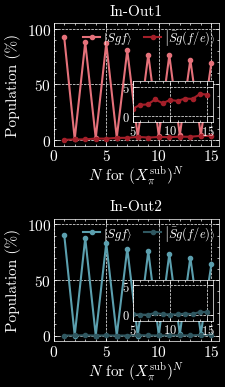

250119_bad_31_00008_good_31_00016_bad_21_00004_good_21_00009_dark
Saving S:\QRAM\qram_4QR2\plots\paper\rb\leakage_error_amp_250119_bad_31_00008_good_31_00016_bad_21_00004_good_21_00009_dark.pdf
Saving S:\QRAM\qram_4QR2\plots\paper\rb\leakage_error_amp_250119_bad_31_00008_good_31_00016_bad_21_00004_good_21_00009_dark.svg


In [ ]:
darkmode = True

from matplotlib.scale import FuncScale
from matplotlib.ticker import AutoMinorLocator

plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use('S:\Connie\prx.mplstyle')
if darkmode: plt.style.use('dark_background')

color_dict = {'good_31': '#5b9faeff', 'bad_31': '#2f5760ff', 'good_21': '#e5717aff', 'bad_21': '#a31f29ff'}

labelsize = 11

color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Custom transformation function
def custom_transform(x):
    new_x = x.astype(np.float64)
    for i, xx in enumerate(x):
        if xx < 2:
            new_x[i] *= 50 / 2  # Compressing factor for values between 0 and 2
        else:
            new_x[i] = 50 + (xx - 2) * (1 + 50 / 98)  # Linear scaling from 2 to 100
    return new_x

# Inverse transformation function
def inverse_transform(x):
    new_x = x.astype(np.float64)
    for i, xx in enumerate(x):
        if xx < 2:
            new_x[i] *= 2 / 50  # Compressing factor for values between 0 and 2
        else:
            new_x[i] = (xx - 50) / (1 + 50 / 98) + 2 # Linear scaling from 2 to 100
    return new_x

fig, ax = plt.subplots(2, 1, figsize=(2.0, 4.1), sharey=False)
plt.subplots_adjust(hspace=0.6) 
plt.subplots_adjust(wspace=0.3) 

plt.sca(ax[0])
plt.grid(which='major')
plt.title("In-Out1", fontsize=labelsize)

name = "good_21"
# label = f"{get_good(2)}gf"
label = "$\\left|Sgf\\right>$"
plt.plot(depths_dict[name], 100*pop_dict[name], 'o-', label=label, color=color_dict[name])
name = "bad_21"
# label = f"{get_bad(2)}gf"
label = "$\\left|\\bar{S}g(f/e)\\right>$"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', label=label, color=color_dict[name])
plt.ylabel(f"Population (%)", fontsize=labelsize)
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(2)}eg\\rangle-|{get_good(2)}gf\\rangle"+"})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|Seg\\rangle-|Sgf\\rangle"+"})^N$"
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax[0].set_xticks(np.arange(0, 16, 5))
ax[0].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
# ax[0].set_yscale(FuncScale(ax[0], (custom_transform, inverse_transform)))
# yticks = [0, 1, 2, 50, 100]
# ax[0].set_yticks(yticks)
# # ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
# ax[0].yaxis.set_minor_locator(plt.NullLocator())
plt.ylim(-5, 105)
# plt.yscale("log")
# plt.ylim(-0.5, 2)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.06), ncol=2, handletextpad=0.2, frameon=False, fontsize=labelsize-2, framealpha=0.75)

# Inset
# left, bottom, width, height = [0.62, 0.71, 0.4, 0.1]
left, bottom, width, height = [0.52, 0.71, 0.4, 0.1]
ax0_1 = fig.add_axes([left, bottom, width, height])
name = "bad_21"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', color=color_dict[name])
print(f"Total leakage after {depths_dict[name][14]} gates (%)", name, 100*pop_dict[name][14])
print("Leakage per gate (%)", name, 100*pop_dict[name][14] / depths_dict[name][14])
plt.ylim(-1.0, 6.0)
plt.xlim(0.35*depths_dict[name][14], None)
plt.grid(which='major')
ax0_1.set_yticks([0, 5])
ax0_1.set_xticks([5, 10, 15])
# ax0_1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax0_1.yaxis.set_minor_locator(plt.NullLocator())
# ax0_1.xaxis.set_minor_locator(plt.NullLocator())
ax0_1.tick_params(axis="both", which="both", labelsize=labelsize-2, pad=2)
# ax0_1.yaxis.tick_right()
# ax0_1.xaxis.tick_top()

plt.sca(ax[1])
plt.title("In-Out2", fontsize=labelsize)
plt.grid(which='major')
name = "good_31"
# label = f"{get_good(3)}gf"
label = "$\\left|Sgf\\right>$"
plt.plot(depths_dict[name], 100*pop_dict[name], 'o-', label=label, color=color_dict[name])
name = "bad_31"
# label = f"{get_bad(3)}gf"
# label = "$\\left|\\bar{S}gf\\right>$ or\n$\\left|\\bar{S}ge\\right>$"
label = "$\\left|\\bar{S}g(f/e)\\right>$"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', label=label, color=color_dict[name])
plt.ylabel(f"Population (%)", fontsize=labelsize)
# label = "$N$ for $(X_{\pi}^{"+f"|{get_good(3)}eg\\rangle-|{get_good(3)}gf\\rangle"+"})^N$"
# label = "$N$ for $(X_{\pi}^{"+f"|Seg\\rangle-|Sgf\\rangle"+"})^N$"
label = "$N$ for $(X_{\pi}^{\mathrm{sub}})^N$"
plt.xlabel(label, fontsize=labelsize, labelpad=0.3)
ax[1].tick_params(axis="both", which="major", labelsize=labelsize, pad=2)
ax[1].set_xticks(np.arange(0, 16, 5))
# plt.ylim(-0.5, 105)
# plt.ylim(-0.5, 2)
plt.legend(loc='upper right', bbox_to_anchor=(1.05, 1.06), ncol=2, handletextpad=0.2, frameon=False, fontsize=labelsize-2, framealpha=0.75)
ax[1].sharey(ax[0])
# plt.yscale('log')

# Inset
# left, bottom, width, height = [0.62, 0.71, 0.4, 0.1]
left, bottom, width, height = [0.52, 0.225, 0.4, 0.1]
ax0_1 = fig.add_axes([left, bottom, width, height])
name = "bad_31"
# label = f"{get_bad(3)}gf"
print(depths_dict[name][:15])
plt.plot(depths_dict[name][:15], 100*pop_dict[name][:15], 'o-', color=color_dict[name])
print(f"Total leakage after {depths_dict[name][14]} gates (%)", name, 100*pop_dict[name][14])
print("Leakage per gate (%)", name, 100*pop_dict[name][14] / depths_dict[name][14])
plt.ylim(-1.0, 6.0)
plt.xlim(0.35*depths_dict[name][14], None)
plt.grid(which='major')
ax0_1.set_yticks([0, 5])
ax0_1.set_xticks([5, 10, 15])
# ax0_1.yaxis.set_minor_locator(AutoMinorLocator(2))
ax0_1.yaxis.set_minor_locator(plt.NullLocator())
# ax0_1.xaxis.set_minor_locator(plt.NullLocator())
ax0_1.tick_params(axis="both", which="both", labelsize=labelsize-2, pad=2)
# ax0_1.yaxis.tick_right()
# ax0_1.xaxis.tick_top()

plt.show()

filepaths_str = folder[5:] + "_" + '_'.join([name + "_" + leakage_paths[name][:5] for name in leakage_paths.keys()])
filepaths_str += '_dark' if darkmode else ''

print(filepaths_str)

savename = os.path.join(save_plot_path, 'rb', f'leakage_error_amp_{filepaths_str}.pdf')
print("Saving", savename)
fig.savefig(savename, transparent=False)

savename = os.path.join(save_plot_path, 'rb', f'leakage_error_amp_{filepaths_str}.svg')
print("Saving", savename)
fig.savefig(savename, transparent=False)

# Bloch sphere for MLE with ZZ

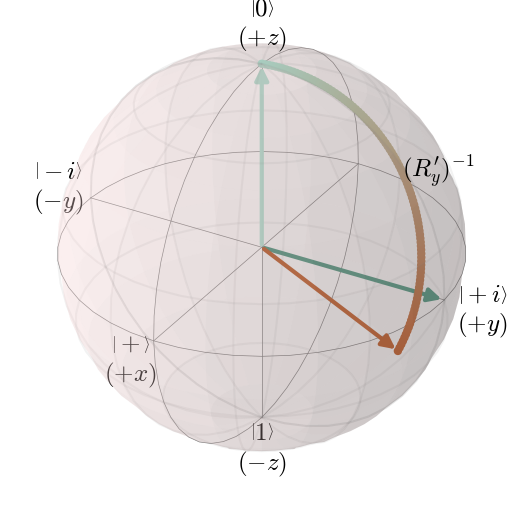

Saving S:\QRAM\qram_4QR2\plots\paper\supmat\zz_correction_trajectory.svg
Saving S:\QRAM\qram_4QR2\plots\paper\supmat\zz_correction_trajectory.pdf


In [674]:
plt.style.use('default') # need to set this first to reset out of dark mode
plt.style.use('S:\Connie\prx.mplstyle')

import qutip_qip.operations as qip
b = qt.Bloch()
b.frame_alpha = 0.1
b.frame_width = 0.5
# b.vector_color = ["#e6a79f", "#b53e2f" , "#518a77"]
b.vector_color = ["#a8cdc0", "#ae592d" , "#518a77"]
b.point_color = color_gradient(b.vector_color[0], b.vector_color[1], 100)
b.zlabel = ['$\\left|0\\right>$\n($+z$)', '$\\left|1\\right>$\n($-z$)'] 
b.xlabel = ['$\\left|+\\right>$\n($+x$)', ""] #, '$\left|-\\right>$\n($-x$)']
b.ylabel = ['$\\left|+i\\right>$\n($+y$)', '$\\left|-i\\right>$\n($-y$)']
fontsize = 18
b.font_size = fontsize

# x = (qt.basis(2,0)+(1+0j)*qt.basis(2,1)).unit()
# y = (qt.basis(2,0)+(0+1j)*qt.basis(2,1)).unit()
z = (qt.basis(2,0)+(0+0j)*qt.basis(2,1)).unit()

# b.add_states(x)
# b.add_states(y)
b.add_states(z)
# b.show()

def good_rot(theta):
    return qip.rx(theta)

def bad_rot(theta, err_x=0.1, err_y=0.2, err_z=0.5, ):
    # return qt.qip.rx(theta)
    return qip.rotation((1+err_x)*qip.x_gate() + err_z*qip.z_gate() + err_y*qip.y_gate(), theta)

def get_traj(U_rot_func, theta_sweep, init_state):
    traj_vecs = [(U_rot_func(theta)*init_state)*(U_rot_func(theta)*init_state).dag() for theta in theta_sweep]
    traj_xs = [qt.expect(qt.sigmax(), vec) for vec in traj_vecs]
    traj_ys = [qt.expect(qt.sigmay(), vec) for vec in traj_vecs]
    traj_zs = [qt.expect(qt.sigmaz(), vec) for vec in traj_vecs]
    return traj_xs, traj_ys, traj_zs 

# b = qt.Bloch()

theta_sweep = np.linspace(0, np.pi/2, 100)

# bad_traj_X_pnts = get_traj(lambda theta: bad_rot(theta).dag(), theta_sweep, x)
# bad_traj_Y_pnts = get_traj(lambda theta: bad_rot(theta).dag(), theta_sweep, y)
bad_traj_Z_pnts = get_traj(lambda theta: bad_rot(theta).dag(), theta_sweep, z)

good_traj_Z_pnts = get_traj(good_rot, theta_sweep, z)

# print(good_traj_xs)

# print(bad_traj_xs)

# b.add_points(bad_traj_X_pnts, meth='l')
# b.add_points(bad_traj_Y_pnts, meth='l')
b.add_points(bad_traj_Z_pnts, meth='m')

b.vector_style = '-|>'
# b.add_states(bad_rot(theta_sweep[-1])*x)
# b.add_states(bad_rot(theta_sweep[-1])*y)

final_bad_state = bad_rot(theta_sweep[-1]).dag()*z
final_good_state = good_rot(theta_sweep[-1]).dag()*z
b.add_states(final_bad_state)
b.add_states(final_good_state)
# b.add_annotation(final_bad_state, "$(R_x')^{-1} \\sigma_z (R_y')$", fontsize=15, verticalalignment='top')
b.add_annotation((final_bad_state + z).unit(), "$(R_y')^{-1}$", fontsize=fontsize, horizontalalignment='left', zorder=10)

b.show()

fig = b.fig
# fig.tight_layout()

savename = os.path.join(save_plot_path, 'supmat', f'zz_correction_trajectory.svg')
print("Saving", savename)
fig.savefig(savename)

savename = os.path.join(save_plot_path, 'supmat', f'zz_correction_trajectory.pdf')
print("Saving", savename)
fig.savefig(savename)

In [180]:
freqs = np.array([-390.00045219204236, 5795.770150727347, 502.42095511476606, -228.8557536534039]) + np.array([7200, 0, 7200, 7200])
print(freqs)

[6809.99954781 5795.77015073 7702.42095511 6971.14424635]
